# Variational AutoEncoder


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

from models import ConvEncoder, VConvEncoder, ConvDecoder, ConvVAE
from VAE_functions import Sampler, nKLDivLoss
from VAE_training import train_epoch, val_epoch

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep


## Dataset and Dataloader

In [4]:
# Dataset

dataset = datasets.MNIST('MNIST', train = True, download = True,
                             transform = transforms.Compose([
                               transforms.ToTensor()
                             ]))

test_data = datasets.MNIST('MNIST', train = False, download = True,
                             transform=transforms.Compose([
                               transforms.ToTensor()
                             ]))

# Divide data dataset in train dataset and val dataset

train_data, val_data = torch.utils.data.random_split(dataset, [50000, 10000])

In [5]:
### Dataloaders
batch_size = 100

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle=True, num_workers=0)



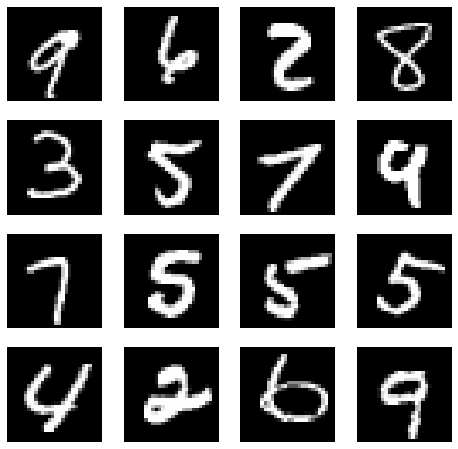

In [6]:
# Plot Mnist
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(1,cols * rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Training

In [7]:
# Check if the GPU is available
#no cuda 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [8]:
### Set the random seed for reproducible results
torch.manual_seed(0)


### Initialize the two networks
encoded_space_dim = 50
net = ConvVAE(encoded_space_dim)


### Move to device
net.to(device)

ConvVAE(
  (encoder): VConvEncoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (5): ReLU(inplace=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (encoder_mean): Sequential(
      (0): Linear(in_features=288, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=50, bias=True)
    )
    (encoder_logvar): Sequential(
      (0): Linear(in_features=288, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=50, bias=True)
    )
  )
  (decoder): ConvDecoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=50, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, ou

In [9]:
# Define the loss function for reconstruction
loss_function = nn.MSELoss(reduction = "sum")

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate

# Define the optimizers
optimizer_1 = optim.Adam(net.parameters(), lr = lr, weight_decay = 0.0)
optimizer_2 = optim.SGD(net.parameters(), lr = lr, momentum = 0.3, weight_decay = 0.1)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[ 0.2273, -0.0017, -0.0176,  0.0735,  0.2278,  0.1848, -0.4126,  0.0871,
          0.1479, -0.0659, -0.2494, -0.2184, -0.3866, -0.1451, -0.0588, -0.2507,
          0.1926,  0.0668, -0.1297, -0.3160, -0.1208,  0.1977, -0.0169, -0.1183,
          0.0429, -0.4056,  0.1986, -0.0896, -0.0938, -0.1979, -0.0188, -0.0053,
         -0.1034,  0.2125,  0.0696,  0.3531, -0.1747,  0.1376, -0.0201, -0.0385,
          0.5637,  0.2528, -0.0664,  0.1089,  0.0470,  0.1691, -0.1257,  0.1706,
         -0.0098, -0.1569]])
tensor([[-0.0688, -0.0209, -0.0317, -0.0095, -0.0840, -0.0455, -0.1562,  0.0066,
          0.0087, -0.0031, -0.0359, -0.0110, -0.2154, -0.0468, -0.1011, -0.0791,
         -0.0257, -0.0650, -0.0012, -0.0352, -0.0395, -0.0481, -0.0359, -0.0762,
         -0.0240, -0.1133, -0.0014,  0.0165, -0.0124,  0.0095, -0.0885,  0.0345,
         -0.0099, -0.0505, -0.0079, -0.1788, -0.1315, -0.0483, -0.0442, -0.0198,
         -0.2664, -0.0191, -0.0340, -0.1403,  0.0040, -0.0715,  0.0218, -0.0264,

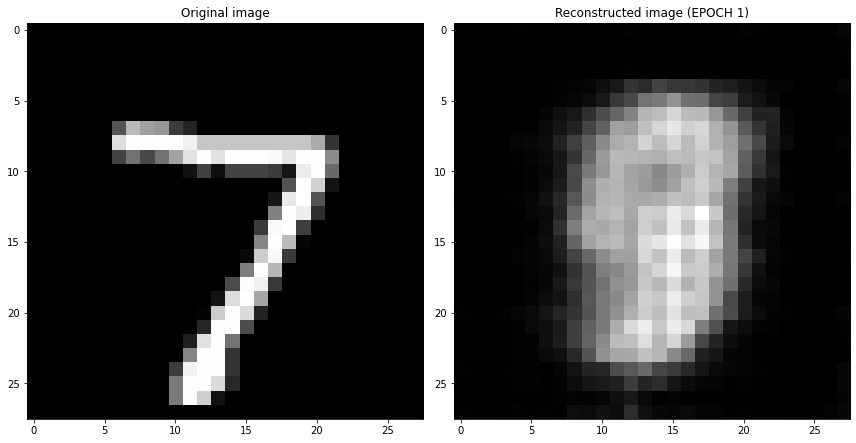

tensor([[ 0.2109,  0.0720,  0.5658,  0.1470,  0.2655, -0.1906, -0.3059, -0.0844,
          0.3255, -0.2707,  0.0072, -0.1518, -0.4697, -0.4450, -0.0683,  0.0888,
          0.4090,  0.1226,  0.3885, -0.5764, -0.3501, -0.3075, -0.1957,  0.7877,
          0.3810, -1.3896,  0.2283, -0.3002,  0.1695, -0.2690,  0.1357, -0.1810,
          0.4028,  0.3317,  0.2434,  0.1153,  0.1374,  0.0569,  0.0477, -0.6389,
          0.8842,  0.0721, -0.1627, -0.0748,  0.3625, -0.0519, -0.1406, -0.1624,
          0.3167,  0.6991]])
tensor([[-3.6935e-02, -3.3867e-02, -4.1155e-02, -4.7924e-02, -3.7606e-02,
         -1.4207e-01, -1.0251e-01, -1.4939e-01,  3.9433e-03, -7.6611e-02,
         -3.3113e-02, -1.4470e-01, -1.3542e+00, -1.3410e-01, -5.0912e-02,
         -8.5470e-02, -1.7205e-01, -2.1998e-01, -1.3226e-01, -1.1496e-01,
         -7.5403e-02, -9.7257e-03, -5.8253e-02, -6.7050e-01, -1.5913e-01,
         -8.1816e-01, -7.4111e-02, -1.1164e-01, -9.4417e-02, -3.1659e-02,
         -1.0052e-01, -4.7225e-02, -1.074

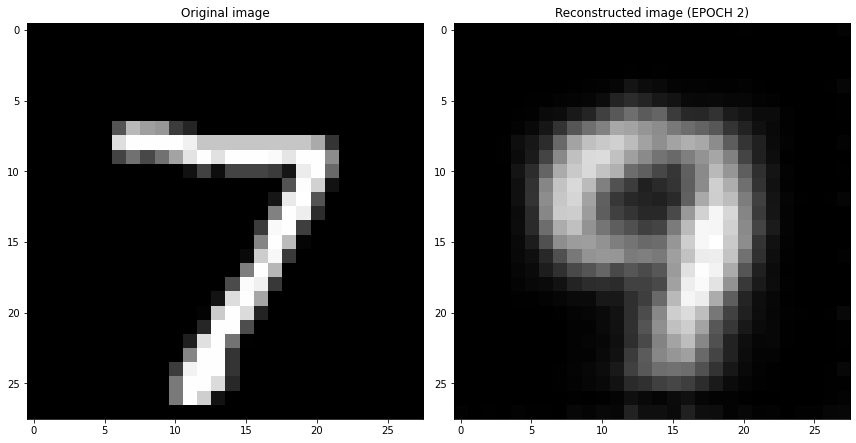

tensor([[ 0.3602,  0.7278,  0.2063,  0.6663,  0.1184,  0.3311, -0.3398,  0.3957,
          0.2920, -0.2111,  0.0461,  0.1407, -0.4304, -0.1997, -0.0949,  0.3824,
          0.7757, -0.2947,  0.4087, -0.5480, -0.6386, -0.2016, -0.3438,  1.5354,
          0.4179, -1.1769,  0.6246, -0.3210,  0.2679, -0.2957, -0.7999, -0.3757,
          0.5726,  0.2914,  0.6546,  0.5406,  0.2926, -0.1236, -0.1218, -0.2959,
          0.6808,  0.2266, -0.8075,  0.0634,  0.7522, -0.3205,  0.1603, -0.2816,
         -0.4700,  0.6390]])
tensor([[-0.0197, -0.1183, -0.0423, -0.1404, -0.0629, -0.0113, -0.0427, -0.1117,
         -0.0131, -0.0040, -0.0124, -0.4164, -2.8578, -0.0240, -0.0293, -0.1626,
         -0.1202, -0.1593, -0.2555, -0.0813, -0.0611, -0.0253, -0.0377, -0.4898,
         -0.1688, -2.1011, -0.1653, -0.0057, -0.0627, -0.1050, -0.1843, -0.0358,
         -0.1317, -0.0183, -0.0672, -0.0568, -0.0421, -0.0119, -0.0514, -0.0549,
         -2.9363, -0.0538, -0.1360, -0.0154, -0.1510, -0.1157, -0.0331, -0.0999,

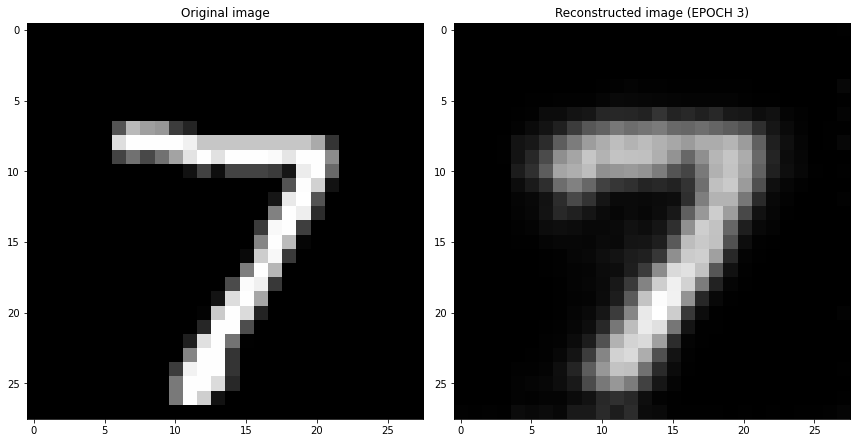

tensor([[ 0.2025,  0.7589,  0.1733,  0.6385,  0.2017,  0.2224, -0.1738,  0.2404,
          0.2262, -0.0164, -0.0202,  0.0256, -0.2199, -0.0402, -0.0672,  0.2587,
          0.6188, -0.4543,  0.5567, -0.4078, -0.3347, -0.2972, -0.1958,  1.6362,
          0.1740, -1.0827,  0.4347, -0.2228,  0.0389, -0.0156, -0.5815, -0.2633,
          0.3466,  0.1590,  0.4991,  0.3274,  0.1180, -0.1087, -0.2213, -0.1637,
          0.5194,  0.2660, -0.4732,  0.0397,  0.4954, -0.2743, -0.0126, -0.0965,
         -0.1948,  0.4829]])
tensor([[-2.2826e-02, -1.4923e-01, -7.4699e-02, -1.5729e-01, -4.1496e-02,
         -5.3516e-02, -3.7134e-02, -6.6345e-02, -3.5214e-02, -1.7621e-03,
         -6.5749e-03, -9.8371e-01, -2.9501e+00, -5.3563e-02, -4.9600e-02,
         -8.4166e-02, -1.1961e-01, -1.2338e-01, -2.4899e-01, -9.8500e-02,
         -6.8600e-02, -5.6299e-02, -2.5311e-02, -7.1203e-01, -1.3346e-01,
         -2.2035e+00, -9.6724e-02, -2.3059e-02, -7.8075e-02, -4.8305e-02,
         -1.1892e-01, -2.2963e-02, -1.106

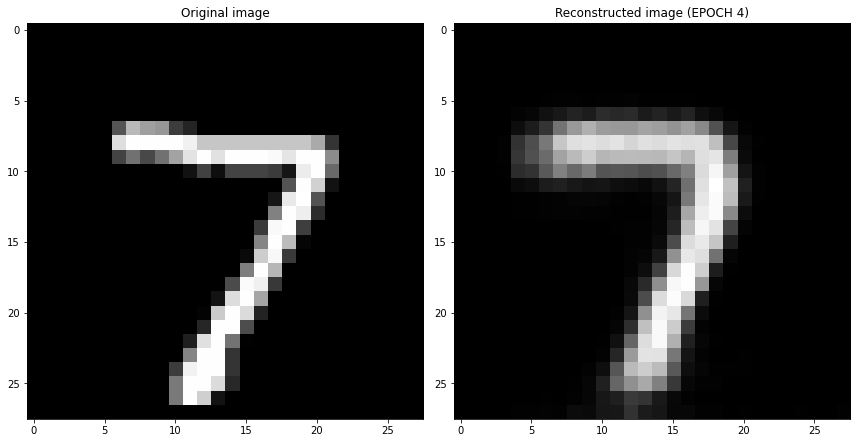

tensor([[ 0.1196,  0.5108,  0.1742,  0.4597,  0.1444, -0.0378, -0.0106,  0.1856,
          0.1199,  0.0052, -0.0365, -0.3376, -0.1407, -0.1286, -0.0203,  0.0693,
          0.3251, -0.5230,  0.4825, -0.2007, -0.1280, -0.1385, -0.0041,  2.2415,
         -0.1335, -1.2144,  0.2076, -0.0966, -0.0409,  0.0488, -0.1158, -0.1331,
          0.2156,  0.0916,  0.2479,  0.1051,  0.0616, -0.0160, -0.1485, -0.1239,
          0.4867,  0.2462, -0.2493, -0.0507,  0.0571, -0.2225, -0.0627, -0.0602,
          0.1296,  0.4681]])
tensor([[-4.5214e-02, -1.3611e-01, -2.3404e-02, -2.0832e-01, -5.0079e-02,
         -6.7072e-03, -1.6722e-02, -1.7971e-01, -3.4663e-02, -2.2897e-03,
          3.5360e-03, -1.6452e+00, -3.3859e+00, -5.6881e-02, -5.6655e-02,
         -7.6786e-02, -7.2825e-02, -1.4919e-01, -1.3723e-01, -2.7974e-02,
         -3.7149e-02, -7.2879e-02,  5.9429e-03, -1.5120e+00, -1.0925e-01,
         -2.3818e+00, -7.3778e-02, -1.0899e-03, -4.3259e-02, -2.9630e-02,
         -8.4290e-02, -4.9944e-02, -4.870

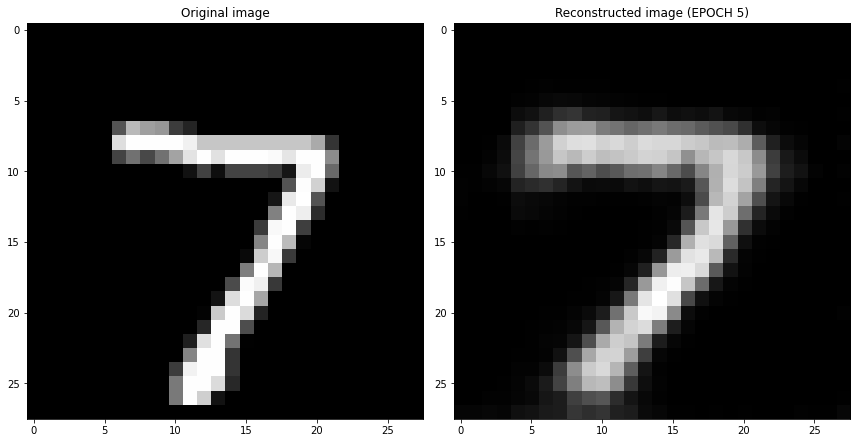

tensor([[-0.0395,  0.3209,  0.0101,  0.1855,  0.1476, -0.0796,  0.0420,  0.2022,
         -0.0472, -0.0397, -0.0124, -0.6867, -0.2284,  0.0350, -0.0863,  0.0524,
          0.1855, -0.3486,  0.2843, -0.1175, -0.0572, -0.1247, -0.0530,  2.1570,
         -0.1255, -1.1918,  0.1031, -0.0607, -0.0332,  0.0161, -0.1131, -0.1229,
          0.0627,  0.0039,  0.0960,  0.0785,  0.0645,  0.0664, -0.1162, -0.1332,
          0.5193,  0.0936, -0.0993,  0.0264, -0.0793, -0.1348, -0.0307, -0.0142,
          0.2340,  0.5680]])
tensor([[-2.3744e-02, -1.8023e-01,  2.8983e-03, -1.5502e-01, -3.0922e-02,
         -1.3662e-02, -2.8445e-02, -2.5177e-01, -3.4313e-02, -1.1827e-02,
          1.4640e-02, -1.9297e+00, -3.6645e+00, -2.2264e-02, -6.1506e-02,
         -5.0649e-02, -5.3044e-02, -2.0499e-01, -1.0947e-01, -1.6981e-02,
         -1.4466e-02, -3.1562e-02, -4.8486e-03, -1.7499e+00, -6.5367e-02,
         -2.2240e+00, -4.6424e-02, -4.2200e-02, -4.3477e-02, -2.8568e-02,
         -1.1470e-01, -3.3615e-02, -3.437

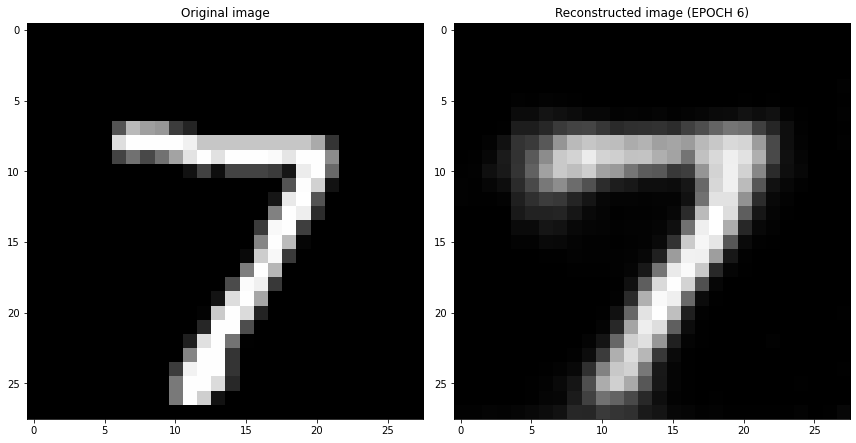

tensor([[-8.8216e-03,  2.5576e-01,  3.4086e-02,  1.4327e-01,  9.4994e-02,
         -1.0370e-01,  4.8810e-02,  1.6514e-01, -3.0237e-02,  1.9266e-02,
          4.1205e-02, -7.5736e-01, -2.3340e-01, -8.4272e-03, -3.1417e-02,
          4.2512e-02,  1.2052e-01, -3.3787e-01,  2.2271e-01, -5.8884e-02,
         -1.5720e-02, -5.5808e-02, -4.4586e-03,  2.1952e+00, -1.0384e-01,
         -1.3311e+00,  7.7041e-02, -3.8889e-03, -1.2351e-03,  5.3392e-02,
         -3.2288e-02, -8.5987e-02,  1.5625e-02, -7.6322e-03,  2.9345e-02,
         -1.7758e-02,  4.1345e-02,  2.3704e-02, -8.6574e-02, -1.1845e-01,
          4.6765e-01,  1.0031e-01, -7.1666e-02, -2.1288e-02, -6.9167e-02,
         -8.1771e-02, -9.3214e-03,  2.9580e-02,  1.9353e-01,  6.7008e-01]])
tensor([[ 2.2964e-03, -1.1098e-01, -1.0758e-02, -1.4556e-01,  1.7809e-03,
         -4.8763e-03, -1.4006e-02, -4.2761e-01, -4.1574e-02, -7.2728e-03,
         -1.0387e-02, -2.0511e+00, -3.7713e+00, -3.2350e-02, -2.8567e-02,
         -3.2649e-02, -4.2240e-02, -

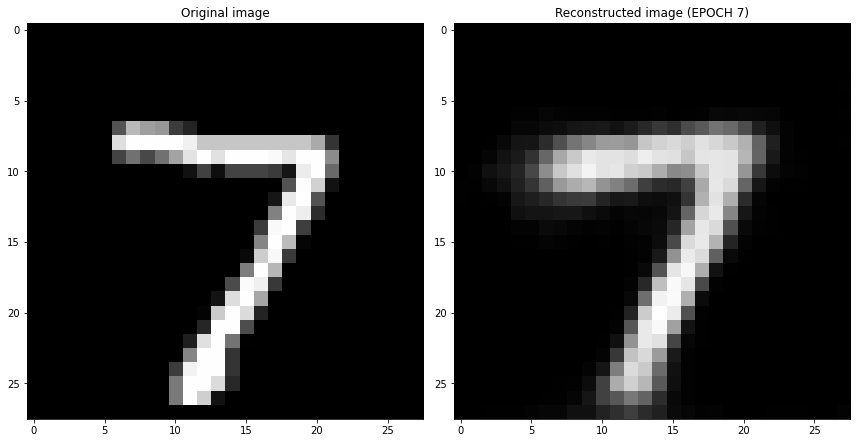

tensor([[ 1.3083e-02,  1.3115e-01,  3.1104e-02,  1.0044e-02,  1.5534e-02,
         -7.7323e-02,  1.2794e-02,  1.7240e-02, -5.6977e-02,  3.6741e-02,
          3.2104e-02, -7.0347e-01, -1.7622e-01, -8.9576e-03, -1.6195e-02,
          5.2057e-02,  8.1146e-02, -3.1645e-01,  9.4020e-02,  2.7590e-03,
         -1.4443e-02, -5.1989e-03,  1.4072e-02,  2.3318e+00, -4.3609e-02,
         -1.2202e+00,  6.8348e-02,  1.8525e-02,  3.8317e-03,  2.0057e-02,
          4.6101e-02, -5.9536e-02, -7.8759e-03, -1.3149e-02,  7.4529e-03,
         -4.0241e-02, -7.8716e-03,  1.0853e-02, -9.5833e-04, -2.6980e-02,
          4.0494e-01,  3.6565e-02, -8.7589e-03, -2.3677e-02, -6.6201e-02,
         -6.9292e-02, -3.5374e-03,  3.6430e-02,  8.3738e-02,  5.0277e-01]])
tensor([[ 1.4663e-02, -2.7101e-02, -4.1817e-02, -9.7479e-02, -2.1652e-02,
          1.3074e-04, -2.8450e-02, -8.1806e-01, -2.7137e-03, -1.7905e-02,
          9.6987e-03, -2.0894e+00, -3.9228e+00, -2.7761e-02, -1.2942e-02,
         -9.5054e-03, -2.6827e-02, -

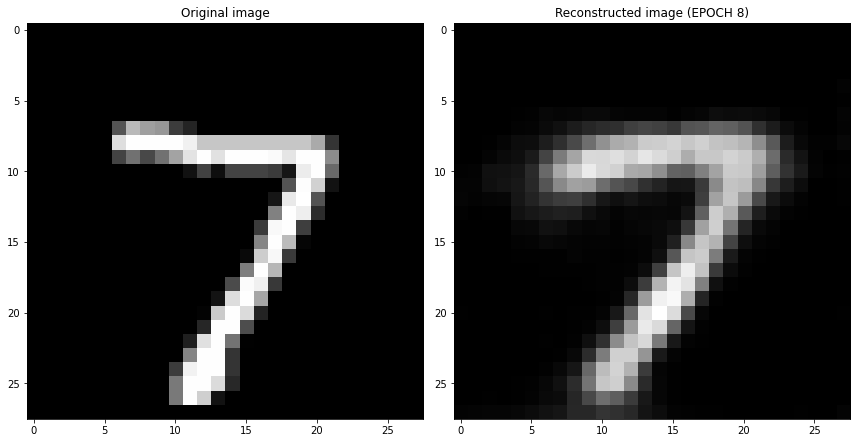

tensor([[ 1.3718e-02,  5.6535e-02, -1.6864e-02, -7.4199e-02, -1.6871e-02,
         -9.6468e-02,  4.5582e-02,  1.3358e-01, -6.8538e-02,  2.4690e-02,
          8.0829e-02, -8.4306e-01, -1.5411e-01,  4.1009e-03, -1.2141e-02,
          7.2783e-02,  2.3744e-02, -2.9862e-01,  2.5475e-02,  2.9170e-02,
          2.0529e-02,  1.8685e-02,  2.3900e-02,  2.1448e+00, -2.1553e-02,
         -1.1519e+00,  3.1575e-02,  1.6902e-02,  8.6174e-03,  1.2776e-02,
          3.1649e-02, -3.2217e-02, -4.4280e-02, -5.7527e-02, -2.7898e-02,
         -2.3334e-02, -7.0035e-03,  2.6240e-02, -1.3353e-02, -2.0348e-02,
          3.6683e-01, -6.4121e-02,  4.0971e-03, -2.3448e-02, -5.8763e-02,
         -2.4962e-02, -3.9492e-04,  4.9625e-02,  5.5189e-02,  6.3476e-01]])
tensor([[ 5.2403e-03, -2.7264e-02, -1.6880e-02, -2.9757e-02, -5.3250e-03,
          1.1099e-02, -2.1358e-02, -1.2994e+00,  6.1695e-05, -2.9084e-03,
          2.0986e-02, -2.2373e+00, -3.8553e+00, -7.9514e-03,  2.1884e-03,
         -1.3200e-02, -1.7197e-02, -

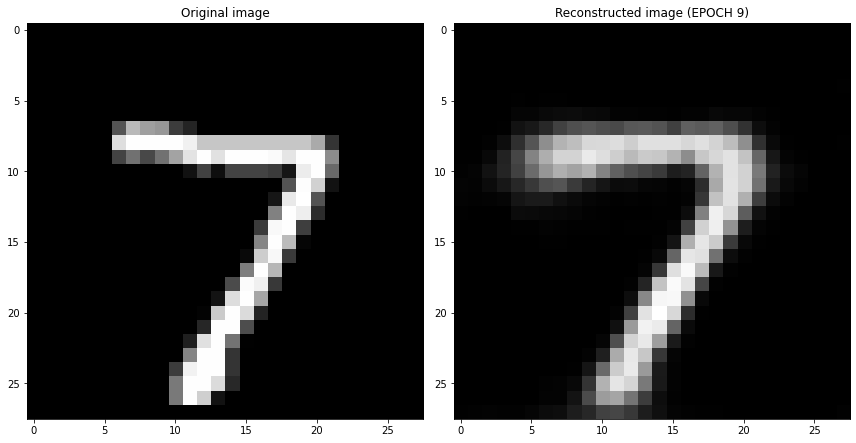

tensor([[ 1.9163e-02,  1.0689e-02, -3.7264e-03, -1.1242e-01, -4.4555e-02,
         -7.5891e-02, -3.2901e-03,  1.6842e-01, -3.4298e-02,  2.4547e-02,
          5.8068e-02, -7.9487e-01, -1.3971e-01, -4.2652e-03,  2.9189e-02,
          6.2542e-02,  4.4265e-02, -3.5921e-01, -2.0387e-03,  1.9480e-02,
          1.6796e-02,  1.1622e-02,  2.1311e-02,  2.1821e+00,  1.7154e-02,
         -1.1235e+00,  4.4616e-02, -3.6755e-02, -2.9175e-02,  1.2900e-02,
          5.1557e-02, -3.3208e-02, -2.8741e-02, -2.5183e-02,  4.4611e-04,
         -3.5444e-02, -6.8303e-03,  2.0789e-02, -5.6205e-03, -1.7362e-02,
          3.1649e-01, -1.3743e-02,  5.5432e-03, -3.3630e-03, -1.7333e-02,
         -2.5940e-02,  3.3399e-02,  7.1361e-02,  3.2792e-02,  6.6198e-01]])
tensor([[ 1.2635e-02, -6.6075e-03, -6.0097e-03, -3.3651e-03, -8.8125e-03,
          8.0299e-04, -7.6298e-03, -1.3926e+00,  5.3963e-03, -9.0398e-03,
         -4.2224e-03, -2.2011e+00, -3.9585e+00,  1.0289e-02, -6.6701e-03,
         -1.2288e-03, -1.3968e-02, -

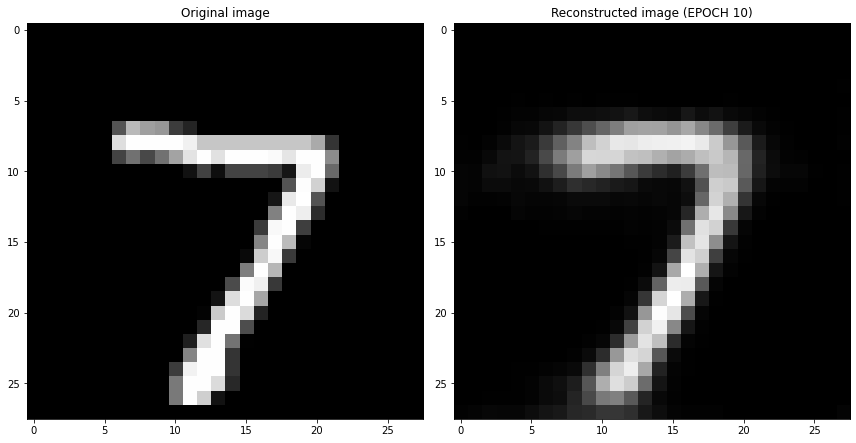

tensor([[-7.5154e-03,  2.9742e-02, -1.2571e-02, -1.2453e-01, -1.9309e-02,
         -4.3086e-02,  2.5526e-02, -9.2256e-04, -7.0926e-03,  2.0541e-03,
          6.7039e-02, -8.7519e-01, -2.2457e-01,  1.5213e-02,  1.5219e-02,
          1.1324e-02,  5.3320e-02, -2.4634e-01,  1.0891e-02,  1.2324e-02,
         -2.0385e-02,  3.0605e-02,  1.0999e-04,  2.2608e+00,  2.0015e-02,
         -1.2040e+00, -6.1050e-04,  3.9835e-03,  2.5897e-02, -4.4594e-03,
          2.2133e-02, -3.1885e-02, -2.5485e-02, -6.7780e-03, -1.8187e-02,
         -1.6789e-02, -6.6299e-04, -5.5597e-03, -3.2420e-02, -6.1457e-03,
          2.8450e-01, -1.9855e-02,  8.8742e-03,  7.1946e-04, -1.6756e-02,
         -8.2873e-03,  2.5411e-02,  1.8054e-02,  9.6293e-03,  6.6631e-01]])
tensor([[ 8.2834e-03,  9.7300e-04, -4.7376e-05, -2.2090e-02, -1.3374e-03,
         -2.3066e-03, -2.3467e-02, -1.7033e+00,  6.9092e-03,  1.0871e-04,
         -7.2420e-06, -2.2143e+00, -3.9114e+00, -6.4106e-03, -5.6437e-03,
         -9.7752e-03, -1.5695e-02, -

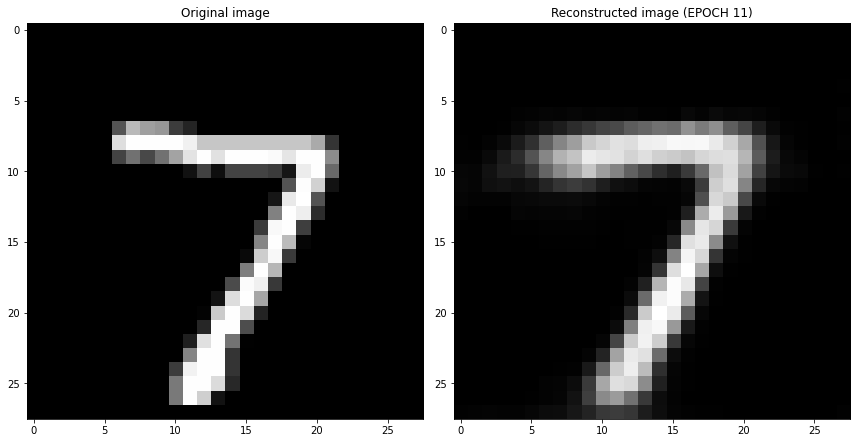

tensor([[ 2.1093e-02, -8.7117e-03, -1.9002e-02, -7.9312e-02, -2.7326e-02,
         -3.4234e-02, -1.7489e-02,  3.3899e-02, -4.4137e-02,  2.6485e-03,
          3.9005e-02, -7.7107e-01, -2.3159e-01,  4.0866e-02,  3.5518e-02,
          1.7700e-04,  2.1041e-02, -1.6462e-01, -1.0232e-03, -1.1507e-02,
          1.1245e-03, -4.6175e-04,  2.2351e-03,  2.1558e+00,  1.0651e-02,
         -1.2733e+00,  2.3566e-02, -2.6184e-02,  2.0172e-03, -1.1043e-02,
         -1.2669e-02, -1.8897e-02, -5.3338e-03, -8.2884e-03, -5.1996e-03,
         -2.4784e-02,  6.6430e-03, -1.8502e-02, -2.1451e-02,  3.2637e-03,
          3.0267e-01,  1.7727e-02,  7.0219e-03, -2.7626e-02,  1.3224e-02,
          2.3620e-02, -8.3755e-03,  3.1634e-02,  2.1688e-02,  6.9202e-01]])
tensor([[-8.5435e-03, -5.4215e-03, -2.1574e-02, -1.5758e-02, -1.4167e-04,
         -1.3118e-02,  4.3597e-04, -1.6256e+00, -5.7427e-03, -7.6789e-03,
         -1.3628e-02, -2.1778e+00, -4.0808e+00, -1.1713e-02,  3.3996e-03,
         -7.2608e-03, -1.0436e-02, -

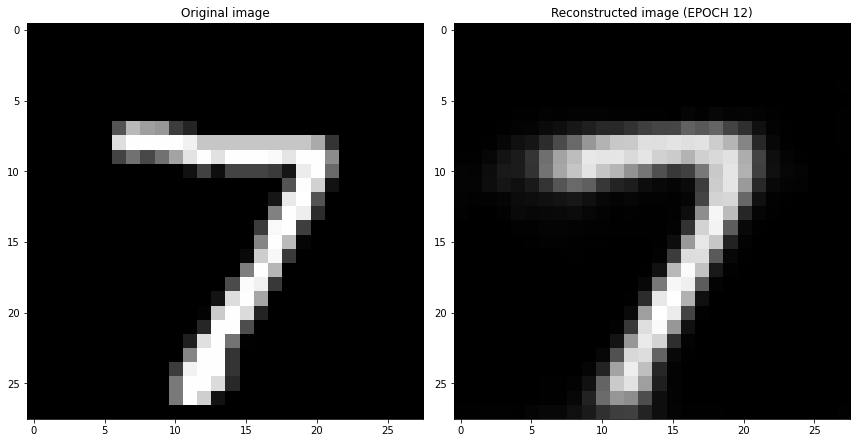

tensor([[ 9.4306e-03,  6.4334e-03, -9.5874e-05, -8.6541e-02, -2.8116e-03,
         -4.7010e-02,  4.6368e-02, -1.5956e-01, -1.7390e-02, -1.2164e-03,
          3.9347e-02, -6.9410e-01, -2.4829e-01,  1.2447e-02, -7.9985e-03,
          3.0949e-03,  2.7216e-02, -2.9116e-01,  1.3931e-02,  3.1751e-03,
          2.5886e-02, -2.3661e-02,  4.3628e-02,  2.2345e+00,  1.5406e-03,
         -1.2042e+00, -7.5588e-03, -2.3492e-02, -1.3841e-02,  5.8067e-03,
         -4.4478e-02,  1.9165e-02,  4.1360e-03,  3.5419e-02, -1.2161e-02,
         -4.7985e-02,  2.4802e-02,  8.5389e-03, -3.2781e-02, -1.0293e-02,
          2.2056e-01,  1.6860e-02,  2.3138e-02, -1.9427e-02, -4.1957e-02,
         -7.6678e-03,  2.2749e-02,  3.6238e-02,  4.6083e-02,  6.1683e-01]])
tensor([[-1.3190e-02,  3.9783e-03, -1.9903e-03, -1.2246e-02,  1.8544e-03,
         -3.6386e-03, -1.0335e-02, -1.7574e+00, -7.2200e-03,  2.6107e-03,
         -4.9080e-03, -2.2807e+00, -4.2113e+00,  5.9156e-03,  5.2837e-03,
         -1.9134e-02, -3.7860e-03, -

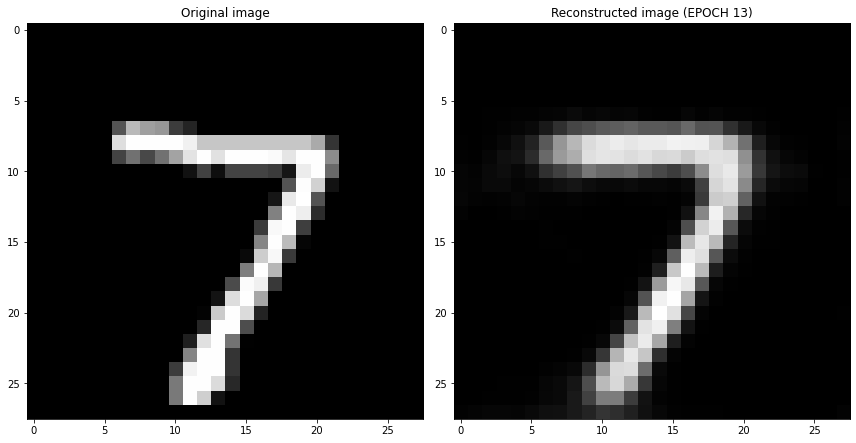

tensor([[-9.3613e-03,  2.7726e-02, -1.5901e-02, -5.3880e-02,  1.6923e-02,
          6.3253e-03, -5.2750e-03,  1.0768e-01, -3.3941e-03,  1.3853e-03,
          4.8825e-03, -7.2340e-01, -2.4477e-01,  1.1107e-02,  1.0152e-02,
          7.1275e-03,  3.4833e-02, -4.2168e-01,  4.1087e-02,  1.0412e-02,
         -2.3984e-03, -6.6915e-03, -2.9308e-02,  2.1546e+00,  1.3986e-03,
         -1.1114e+00,  1.7246e-03, -1.8543e-02,  1.1743e-02, -3.0991e-02,
          2.2634e-02, -6.5344e-03,  1.4176e-02,  7.7392e-03,  6.1257e-03,
         -1.0563e-02,  1.3033e-02, -1.1880e-02,  8.5706e-03, -3.7356e-02,
          3.0520e-01, -3.2689e-05,  3.3376e-02, -5.2877e-02, -5.8961e-03,
          1.3906e-02, -1.0958e-03,  6.7580e-03,  5.3993e-02,  5.9294e-01]])
tensor([[ 1.6354e-03, -1.0042e-02, -3.9785e-03, -8.3169e-03, -3.6414e-03,
         -2.5965e-02, -3.1513e-03, -1.6970e+00,  7.6864e-03,  8.3489e-04,
         -2.4167e-03, -2.1331e+00, -4.0005e+00, -4.1625e-03,  5.3167e-03,
         -1.0052e-02, -1.4115e-03, -

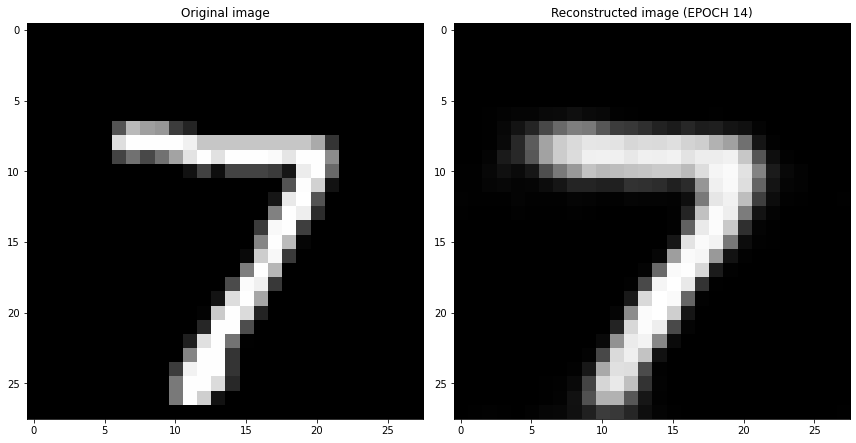

tensor([[ 4.7046e-03, -1.4753e-02,  1.4756e-03, -3.8048e-02, -1.1629e-03,
          8.6522e-03, -3.2202e-02,  2.1252e-02,  9.0331e-03, -6.4224e-05,
          5.8838e-03, -7.9785e-01, -2.4917e-01, -1.4784e-02, -2.0641e-03,
          3.3073e-02,  1.2982e-02, -3.5451e-01, -6.3489e-03, -7.6288e-03,
          1.3744e-02, -1.8054e-02, -2.2859e-04,  2.0349e+00,  2.2825e-02,
         -1.2259e+00, -3.0475e-03, -8.1793e-03,  2.5576e-02, -1.0757e-02,
          3.9389e-02, -1.9799e-02,  9.4762e-03,  4.1984e-03, -2.4755e-03,
         -1.2600e-02,  1.4931e-02, -2.4434e-02, -9.7425e-04,  5.6818e-04,
          3.3822e-01, -1.0915e-02, -1.4532e-02, -3.1921e-02,  6.2721e-03,
          1.4144e-02,  1.4095e-02,  8.4489e-03,  2.4415e-03,  6.6225e-01]])
tensor([[-2.9934e-03, -1.5618e-02, -5.2830e-03, -8.9834e-03,  3.8406e-03,
         -1.4450e-03, -8.4926e-03, -1.7095e+00,  4.4249e-03, -8.8111e-03,
         -1.0296e-02, -2.2631e+00, -3.9116e+00, -1.4751e-02,  2.5347e-03,
         -2.4966e-03, -1.5833e-02, -

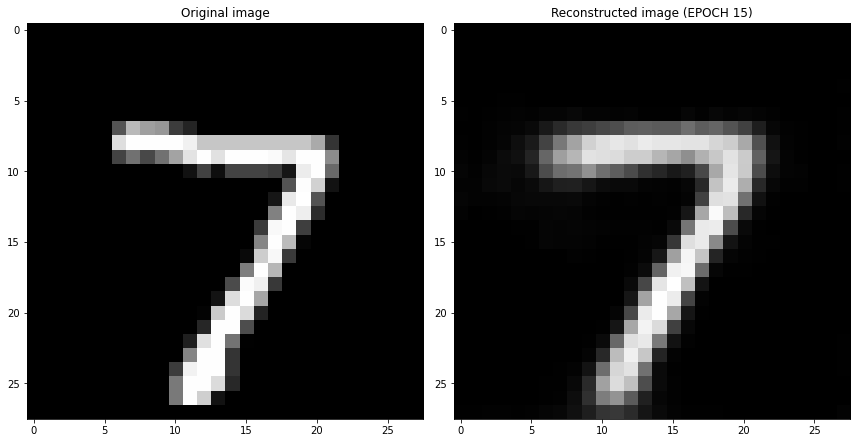

tensor([[ 7.8438e-03, -2.0175e-02,  8.8201e-03,  2.5313e-03,  2.0211e-02,
         -4.9481e-03, -5.6992e-02, -1.1596e-01, -1.3512e-02, -3.0166e-04,
         -7.7084e-03, -7.6590e-01, -2.6593e-01, -9.0202e-03,  2.5524e-02,
         -1.1196e-02,  3.1237e-02, -3.2276e-01, -1.5894e-02,  1.6843e-02,
         -6.6904e-03, -1.5605e-02, -1.1903e-02,  2.3540e+00, -3.3507e-04,
         -1.1501e+00, -6.8137e-03, -3.0134e-02, -8.2217e-03,  1.3080e-02,
         -8.9165e-03, -2.2705e-02, -3.0232e-02,  7.8134e-04, -9.2769e-03,
         -1.4863e-02,  1.8915e-02,  1.1731e-02, -8.9900e-03, -4.7561e-02,
          2.7554e-01,  1.6405e-02,  5.0399e-02, -1.9160e-02,  2.1815e-02,
          4.0168e-02,  4.7354e-02,  2.1573e-02,  5.9946e-02,  5.5506e-01]])
tensor([[-7.9559e-03,  7.8439e-03,  2.1640e-03, -9.9872e-04,  2.2947e-03,
         -1.1778e-02, -6.6895e-04, -1.6909e+00, -4.8327e-03, -8.0180e-03,
          2.1566e-03, -2.1428e+00, -4.0007e+00, -1.5403e-02,  1.1243e-02,
         -2.1534e-03,  3.6065e-04, -

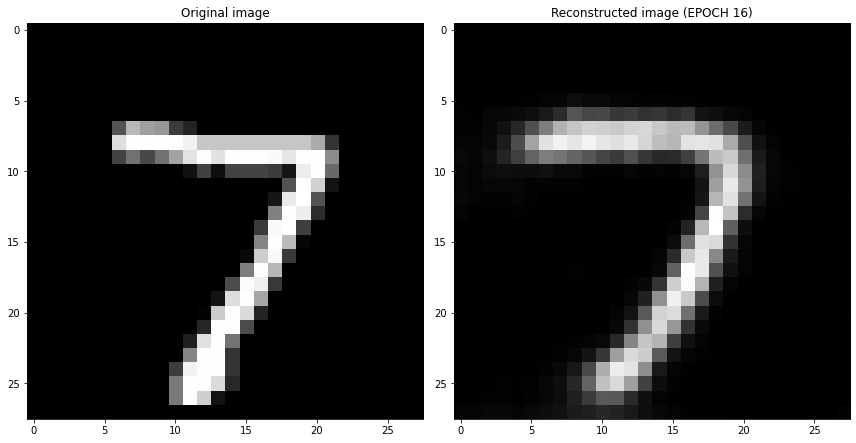

tensor([[-2.7543e-03,  8.4839e-03,  1.3152e-02,  2.2160e-02,  4.1275e-03,
          3.4231e-03, -2.1254e-03, -1.3980e-01, -3.7410e-02, -2.1806e-03,
          1.3472e-02, -8.4432e-01, -2.6339e-01,  8.3981e-04,  2.2504e-02,
         -1.5455e-02,  2.1629e-02, -4.5838e-01, -1.1513e-02, -4.2131e-03,
          2.0861e-03, -1.4000e-03, -1.1038e-02,  2.1634e+00,  4.1875e-02,
         -1.1934e+00,  1.5068e-02, -1.3443e-02, -2.8814e-03,  1.0699e-02,
         -1.0545e-02,  1.6061e-03, -1.0510e-02, -4.6467e-03,  1.0747e-02,
          1.1504e-02, -1.2630e-02, -1.1219e-02, -2.1186e-02, -3.2134e-02,
          2.5287e-01,  4.8421e-03,  1.1811e-03, -3.6149e-02, -1.0093e-02,
          2.9735e-02,  2.7551e-02,  4.3562e-02,  1.9178e-02,  5.9442e-01]])
tensor([[ 5.6629e-04,  4.3571e-03, -1.6722e-03, -2.4383e-03, -6.0811e-03,
          7.2017e-04, -6.3202e-03, -1.6094e+00, -2.1220e-03, -1.1508e-02,
         -3.5158e-03, -2.1928e+00, -4.0751e+00,  5.8843e-03, -4.4145e-04,
          1.4203e-03,  8.3210e-03, -

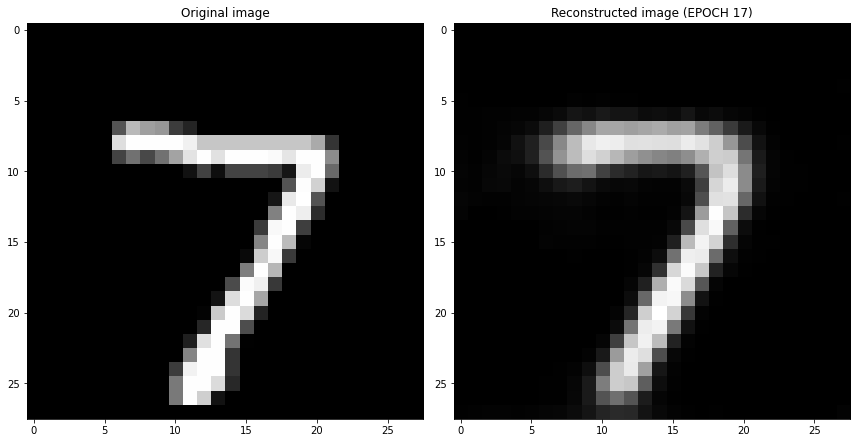

tensor([[ 5.3270e-04,  3.6789e-02,  5.5804e-03,  2.0929e-02,  5.0304e-03,
         -3.6535e-03, -5.5356e-03,  7.5757e-02, -1.5901e-02,  1.2018e-02,
         -7.1977e-03, -8.1809e-01, -1.8779e-01,  1.0279e-02, -1.3089e-02,
          5.4806e-04, -8.1583e-03, -4.5870e-01, -1.4668e-02,  1.4924e-02,
          2.7415e-02,  6.5961e-03,  1.2335e-02,  2.2167e+00,  2.1921e-03,
         -1.1820e+00, -8.0897e-03,  2.8810e-03, -1.4701e-02,  2.4628e-03,
          2.6282e-02, -7.4653e-03, -2.1516e-02, -2.5453e-02,  3.1699e-02,
          2.1193e-02,  9.2477e-05, -7.6393e-03, -2.7149e-02, -3.0902e-02,
          2.6383e-01,  2.0637e-03, -1.8669e-02, -2.3676e-02, -2.1793e-02,
          2.8094e-02,  4.9014e-03,  2.0949e-02,  2.0761e-02,  6.8550e-01]])
tensor([[-4.6675e-03, -1.7150e-02, -5.8756e-04, -1.9582e-03,  5.9359e-03,
         -4.8963e-03, -1.2879e-02, -1.7106e+00,  3.0573e-03, -1.1435e-03,
         -1.5169e-02, -2.2340e+00, -4.1303e+00,  1.5123e-03, -9.4207e-03,
         -3.2520e-03, -6.7575e-03, -

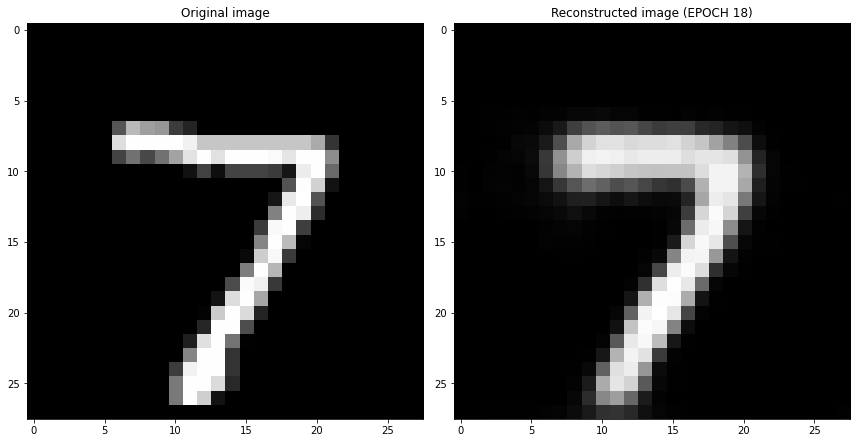

tensor([[ 5.7177e-04,  5.0695e-03, -4.9769e-03,  2.2651e-02, -2.8414e-02,
          1.7332e-02, -3.4025e-02, -1.4577e-01, -2.5880e-02, -3.0388e-03,
         -2.7630e-03, -8.1108e-01, -3.0571e-01, -8.0619e-03, -1.0428e-02,
         -4.4555e-02,  1.5614e-02, -3.3238e-01,  6.1591e-03,  1.6788e-02,
         -1.6485e-03,  7.2024e-04, -8.0743e-03,  2.3777e+00,  1.9843e-02,
         -1.2048e+00,  1.1061e-02, -4.3204e-03, -1.9569e-02,  1.8876e-02,
          1.7304e-02,  1.8336e-02, -2.3690e-02,  3.0786e-02, -2.8931e-02,
          9.8362e-03, -9.2251e-03,  1.6221e-03, -2.5347e-02, -3.2649e-02,
          2.0572e-01, -1.6100e-02,  3.6816e-02, -1.5743e-02, -1.5164e-03,
          1.0748e-02, -8.7666e-03, -9.2069e-03, -3.0353e-02,  5.6453e-01]])
tensor([[-6.6477e-03, -1.2548e-02, -6.4171e-03,  3.5637e-03, -3.1870e-03,
         -3.0947e-03, -3.6343e-03, -1.7849e+00,  5.3329e-03,  7.8753e-04,
         -1.5216e-02, -2.2230e+00, -4.0224e+00, -4.7335e-03, -6.2749e-03,
         -3.3381e-03, -1.5040e-02, -

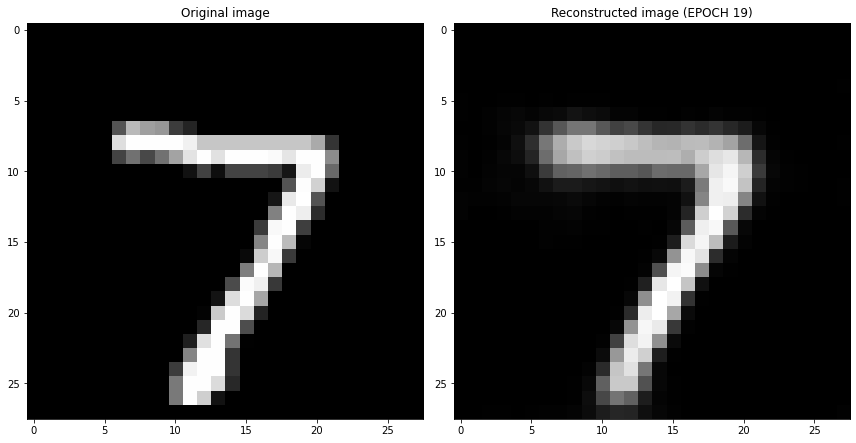

tensor([[-1.2842e-02, -1.7994e-02, -2.0595e-02,  9.5975e-05, -3.9781e-03,
          8.6238e-03,  1.8832e-03, -1.6888e-01,  2.0311e-04,  1.1416e-03,
         -2.1737e-02, -8.4389e-01, -2.5878e-01, -2.3375e-02,  1.8448e-02,
         -3.5746e-03,  2.3611e-02, -5.0105e-01,  1.0761e-02,  4.8043e-02,
          1.7096e-02, -7.7495e-03, -1.9233e-02,  2.2124e+00,  1.4474e-02,
         -1.2889e+00,  4.1978e-02, -1.6235e-02, -1.0567e-02, -1.8640e-02,
          3.7987e-02,  1.1616e-03, -8.1888e-03, -1.3520e-02, -2.3004e-02,
         -8.6228e-03,  2.9610e-03,  6.3062e-03, -1.9083e-02, -1.6209e-02,
          2.9530e-01, -2.7896e-03, -5.4490e-03,  1.5013e-02, -9.5276e-03,
          4.9358e-03,  3.9313e-03,  2.3685e-02, -3.5229e-03,  6.3487e-01]])
tensor([[-1.3284e-03, -4.0649e-03, -6.9728e-03, -1.5790e-05, -1.7090e-02,
          1.0352e-02,  2.1062e-04, -1.6967e+00, -2.6480e-03,  4.5245e-03,
          7.3840e-04, -2.1454e+00, -4.1344e+00, -4.3916e-03, -1.5350e-04,
         -2.5555e-03, -1.2534e-02, -

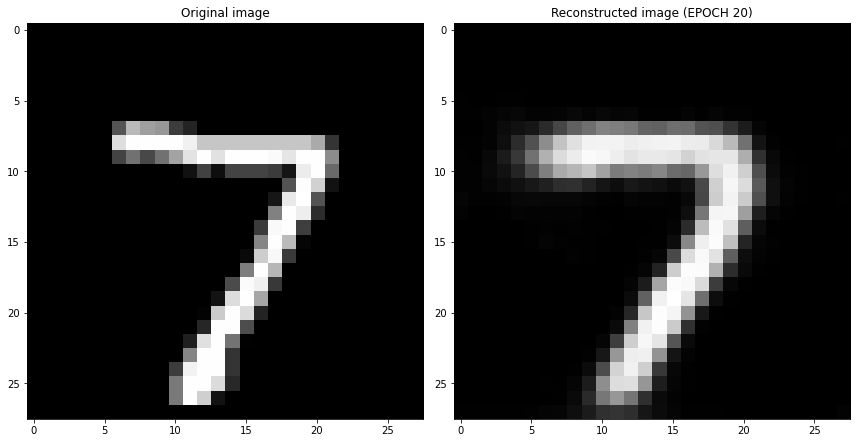

tensor([[-4.3167e-03,  3.0736e-02, -8.7127e-03,  9.9301e-03,  1.7347e-02,
          1.4516e-03, -2.0535e-02, -1.7105e-02, -1.9943e-02, -1.8565e-02,
          2.3891e-02, -9.2206e-01, -2.6725e-01,  1.4085e-02,  3.9894e-02,
         -3.5156e-03, -1.5536e-02, -5.8676e-01,  4.5343e-03,  1.7195e-02,
          2.2299e-03, -2.6864e-03,  7.8547e-03,  2.1178e+00,  3.8659e-02,
         -1.2728e+00,  7.2100e-03, -4.0049e-03,  2.5108e-02, -2.6887e-03,
          2.1562e-02,  6.2267e-03,  9.2307e-03,  7.9426e-03, -1.0176e-02,
          1.8096e-02,  1.7673e-02, -1.5826e-02, -1.2407e-02, -4.3419e-02,
          1.7875e-01,  7.9200e-04, -9.2131e-03, -1.6027e-02, -1.2462e-02,
          2.6061e-02, -2.6809e-02,  2.0288e-02,  1.1132e-02,  6.0814e-01]])
tensor([[ 4.1924e-03, -1.0847e-03, -1.1227e-02, -8.2676e-03, -2.1820e-02,
         -3.8111e-03, -1.6458e-06, -1.7001e+00, -3.7046e-03, -8.7383e-03,
         -2.1159e-02, -2.1760e+00, -4.0857e+00, -5.7370e-03, -7.7702e-03,
         -1.0304e-02, -9.1956e-03, -

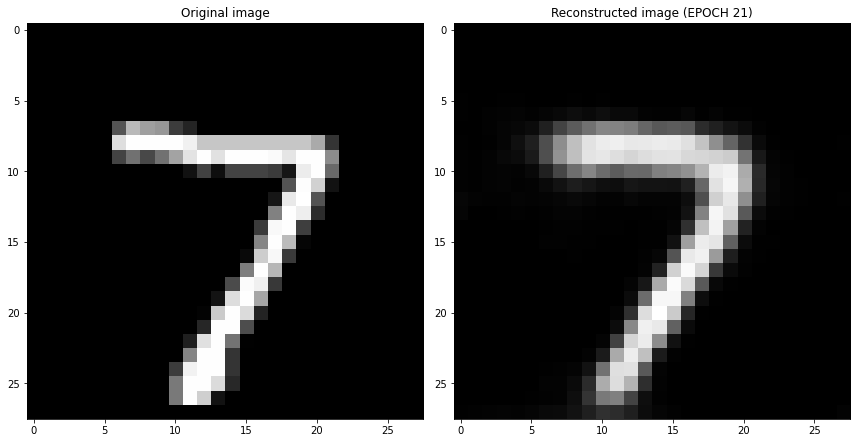

tensor([[ 1.1349e-02,  5.7997e-03, -3.1642e-03,  4.1046e-02,  1.3995e-02,
         -7.4262e-03,  7.2570e-03, -1.0631e-01, -1.9657e-02, -1.6959e-02,
         -2.4552e-03, -1.0510e+00, -2.9625e-01, -4.8945e-02, -7.5470e-03,
          2.5089e-02,  3.7417e-02, -4.5837e-01,  7.1378e-03, -1.3381e-02,
          4.5283e-03,  1.0703e-03, -5.4116e-03,  2.3546e+00,  3.8761e-02,
         -1.2171e+00,  6.7240e-03, -3.6352e-02,  2.4772e-02, -2.4401e-02,
          1.6217e-02,  1.8621e-03,  4.3281e-03,  1.4089e-02, -3.9198e-02,
          9.4260e-03,  4.0452e-03,  1.1797e-02, -1.8678e-02, -1.2800e-02,
          1.0902e-01,  1.0700e-03,  5.8546e-02, -1.0887e-02,  1.3891e-03,
         -5.4302e-03,  1.6856e-02,  1.7016e-03, -9.2864e-03,  5.8930e-01]])
tensor([[ 7.8953e-03, -6.5951e-03, -3.2799e-03,  2.6577e-03, -1.4663e-03,
          1.4130e-02,  2.1479e-03, -1.7485e+00,  9.2705e-04, -1.1189e-02,
         -1.7418e-02, -2.2622e+00, -4.0283e+00,  1.8156e-03, -4.4699e-03,
         -9.1265e-03, -1.0632e-02, -

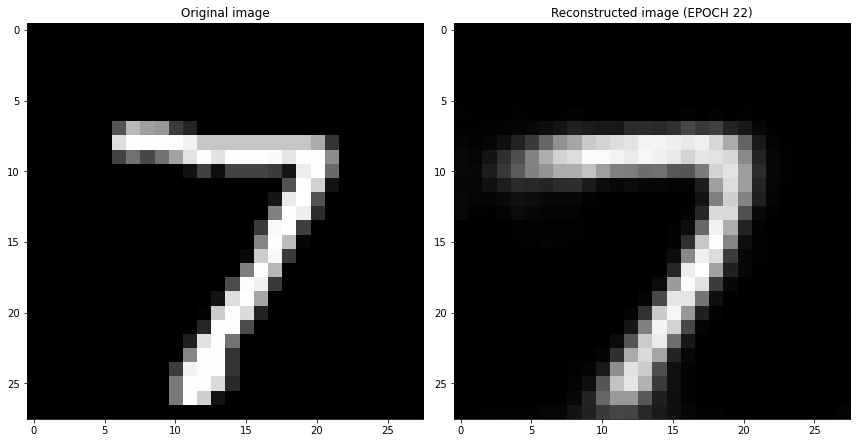

tensor([[-7.3013e-04,  1.1955e-02, -2.2478e-02,  1.3098e-02,  3.2569e-03,
          1.2973e-02, -1.8294e-02, -2.0075e-01,  2.7564e-03, -3.0712e-03,
          8.7669e-03, -9.6457e-01, -4.1508e-01, -1.7450e-02,  3.6971e-03,
          9.8861e-03,  6.7723e-03, -4.4235e-01,  3.1940e-02,  5.7019e-03,
          3.4131e-02, -6.2581e-03,  1.3962e-03,  1.9889e+00,  1.7704e-02,
         -1.2485e+00,  9.6283e-03, -1.5448e-02,  1.0809e-02,  9.7010e-03,
         -3.9287e-02, -5.0862e-03,  1.9920e-02,  9.2583e-04, -3.4554e-03,
         -4.4163e-03,  2.0767e-02, -3.1141e-02,  1.6047e-02,  1.6801e-02,
          2.3523e-01, -4.5532e-04, -1.0373e-02, -1.8375e-02, -4.3810e-03,
         -1.4992e-02, -3.0685e-02, -1.1100e-02, -1.0205e-02,  5.9259e-01]])
tensor([[-2.0083e-03, -6.3901e-04, -5.5718e-03,  4.7423e-03,  8.6879e-03,
         -3.0537e-03,  7.4857e-03, -1.6696e+00, -8.3287e-04,  4.4957e-03,
          6.5575e-03, -2.1375e+00, -3.9145e+00, -1.1940e-02,  9.2509e-03,
         -6.3633e-03,  6.5802e-03, -

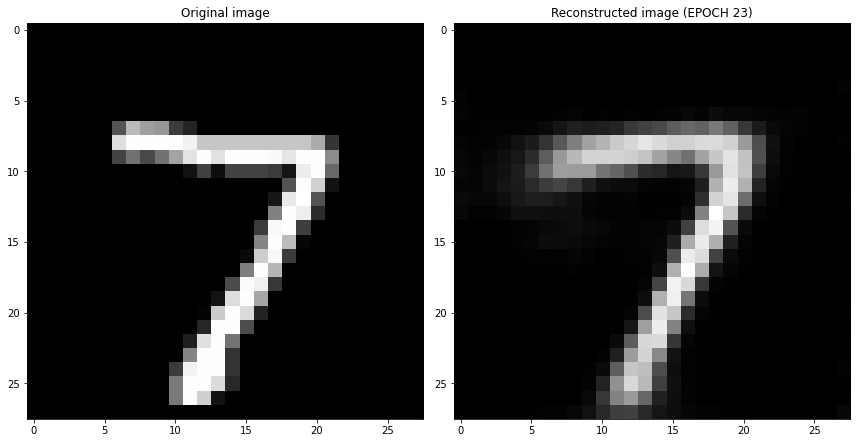

tensor([[ 1.6376e-02, -8.4860e-03, -4.3451e-03,  1.5353e-02,  1.1241e-02,
          1.4206e-02, -2.6201e-02, -3.0334e-01, -1.6798e-02, -1.7502e-03,
         -4.5537e-03, -8.6595e-01, -3.1656e-01, -2.8446e-02,  1.2971e-02,
         -2.0771e-02, -1.0715e-03, -4.4540e-01,  4.0131e-04,  2.1541e-02,
          4.9665e-02, -9.3697e-03,  7.0750e-03,  2.1825e+00, -1.1015e-02,
         -1.2698e+00,  8.4240e-03, -2.5868e-02,  1.2475e-02,  1.5344e-02,
          3.4319e-02, -8.2010e-04,  1.5271e-02,  3.2218e-02,  1.1600e-02,
          9.3055e-03,  5.7331e-02, -2.8354e-03,  1.6815e-02, -3.3243e-02,
          1.3633e-01, -4.6217e-03, -2.9893e-03, -1.7734e-02,  9.5486e-03,
          3.1729e-02, -2.0871e-03,  2.9787e-02,  1.1042e-02,  5.0020e-01]])
tensor([[-1.2884e-02, -1.0777e-02, -6.3483e-03, -7.3642e-03,  1.2282e-02,
         -8.5260e-04, -2.7793e-03, -1.6273e+00,  6.2199e-03, -3.6062e-03,
          1.6188e-04, -2.1898e+00, -4.1365e+00, -1.4183e-02, -7.4179e-03,
         -1.8291e-02, -1.3519e-02, -

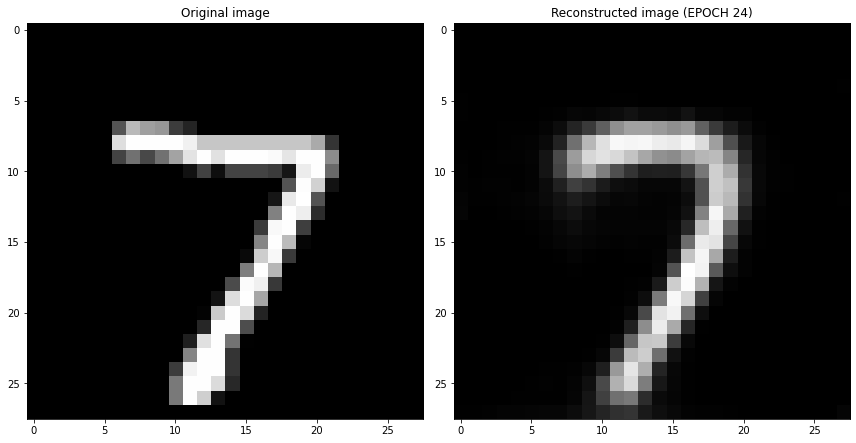

tensor([[-1.9626e-02,  9.0074e-03,  2.1471e-02,  3.2901e-03,  1.8709e-02,
         -2.1205e-02, -3.5581e-02, -1.2538e-01,  3.8202e-03,  3.3531e-02,
         -3.2998e-03, -9.4395e-01, -2.3932e-01, -2.5160e-02,  1.8133e-02,
         -2.5720e-02,  2.7534e-02, -5.1337e-01,  1.5515e-02,  2.6100e-02,
         -7.5779e-03, -1.4853e-02,  1.5478e-02,  2.2081e+00, -5.5096e-02,
         -1.2868e+00,  2.5100e-02, -1.7510e-03, -6.3491e-03, -1.4548e-02,
          6.5933e-02,  6.8115e-03, -2.8102e-03,  2.6364e-02, -1.7072e-02,
         -1.2112e-02, -1.4746e-02,  9.7637e-04, -1.0506e-03,  2.3602e-03,
          1.2549e-01, -1.4665e-03, -2.7691e-02,  2.1982e-03,  4.4227e-02,
         -5.9551e-03,  3.3190e-03,  1.4582e-02,  1.0849e-02,  5.3131e-01]])
tensor([[-3.1665e-03, -3.4772e-03,  4.4808e-03, -2.1570e-02, -9.2507e-03,
         -7.2656e-03,  9.6233e-03, -1.6636e+00, -6.0689e-03, -2.5172e-03,
         -7.3620e-04, -2.0918e+00, -3.9904e+00,  3.5019e-03, -6.3618e-03,
          6.7095e-03,  1.2637e-03, -

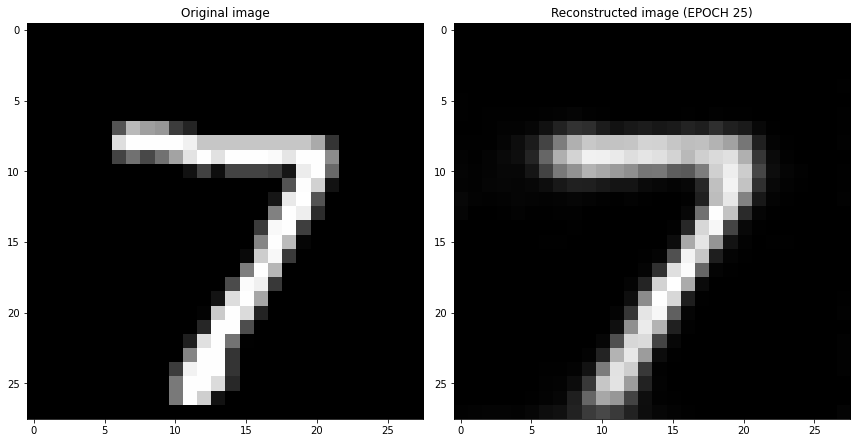

tensor([[ 6.9243e-03,  1.5101e-02,  4.7624e-02,  2.0923e-02, -5.5765e-03,
         -1.1080e-02, -4.2235e-02, -1.0947e-01,  1.9151e-02, -6.7182e-03,
         -2.5344e-02, -1.0848e+00, -2.0379e-01,  2.2867e-02,  3.8656e-02,
         -1.8485e-02,  2.6162e-02, -4.1867e-01, -9.2651e-03, -7.0507e-03,
         -1.5103e-02,  1.7393e-02,  3.5105e-05,  2.1658e+00,  1.0630e-02,
         -1.2487e+00,  3.6101e-02,  2.8040e-02,  2.0462e-02, -1.2968e-02,
          1.3288e-02,  4.3108e-03,  4.8586e-02,  2.7993e-02, -4.1422e-03,
         -4.2016e-02,  2.9122e-02, -3.9141e-02,  2.2761e-03, -1.8677e-02,
          1.4644e-01,  8.5932e-04,  1.6227e-02, -2.0948e-02,  6.9636e-03,
         -1.2894e-02, -1.9701e-02,  4.1894e-02,  3.8041e-02,  5.5290e-01]])
tensor([[-5.5825e-04, -4.5715e-05, -1.6173e-02, -1.4984e-02, -1.0797e-02,
         -1.3606e-02,  1.0909e-02, -1.6361e+00, -7.5702e-04, -3.5445e-03,
         -3.0758e-03, -2.1951e+00, -4.0671e+00, -8.7610e-03,  8.3951e-03,
         -7.2710e-03, -9.3129e-03, -

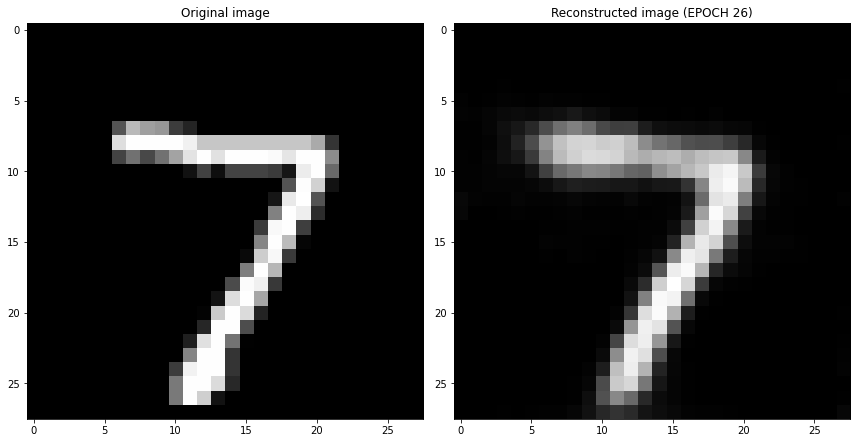

tensor([[ 1.0610e-02, -5.7477e-03, -1.9338e-03, -2.1707e-02,  1.2319e-02,
          5.3047e-03, -1.7522e-02, -9.6329e-02,  4.1787e-03, -1.5029e-02,
          5.9975e-04, -9.4023e-01, -2.8185e-01,  5.7871e-03,  1.3781e-03,
         -2.0118e-02, -6.0191e-03, -4.3165e-01,  1.1623e-02,  1.9130e-02,
         -7.4993e-03,  8.6993e-03,  3.3120e-02,  2.1780e+00, -5.7959e-03,
         -1.2695e+00,  7.3499e-03,  1.6118e-03, -1.0952e-02,  4.3260e-04,
          2.0344e-02, -1.4686e-02,  4.0782e-03,  1.3987e-02,  1.6002e-03,
         -7.6165e-03, -2.7333e-03, -1.1334e-02, -1.2783e-02,  3.4231e-03,
          1.7753e-01,  6.6837e-03,  1.4673e-02, -2.7243e-03,  1.2781e-02,
          5.4790e-03, -3.3292e-03, -1.5601e-02,  1.1860e-02,  4.4124e-01]])
tensor([[-1.2941e-03, -1.3578e-02, -1.0141e-02,  6.9709e-04,  1.3410e-02,
         -1.5420e-03, -5.6780e-03, -1.6592e+00,  3.0037e-03,  4.6471e-03,
         -1.0685e-02, -2.0887e+00, -4.0251e+00, -5.5640e-03, -3.7039e-03,
         -3.2554e-03, -1.3592e-03, -

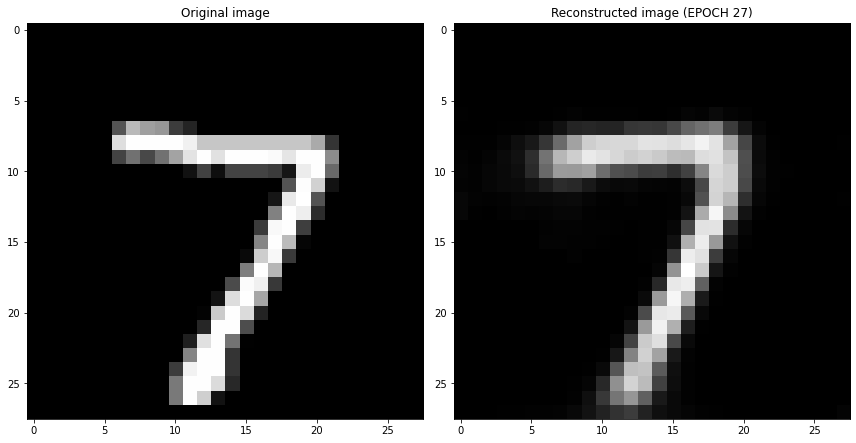

tensor([[ 1.8635e-03,  2.4857e-03,  2.1018e-02,  2.9211e-03,  2.3959e-02,
          3.7639e-03, -1.2433e-02, -1.8981e-01,  3.1194e-02,  1.7689e-03,
         -1.3836e-02, -9.1873e-01, -2.1375e-01, -5.0572e-03, -1.7437e-02,
         -2.3082e-02, -2.8260e-03, -4.2224e-01,  2.0374e-02, -3.6273e-04,
         -3.6294e-02, -1.9347e-02, -1.8020e-02,  2.2545e+00,  8.0630e-03,
         -1.2379e+00, -1.9942e-02, -1.4456e-02,  8.2535e-03, -4.6112e-03,
          1.6758e-03, -1.1709e-02, -7.8127e-03,  2.6814e-02,  4.4009e-03,
          1.1412e-02, -9.0021e-03, -6.2570e-02,  2.2400e-02, -3.3970e-02,
          1.0863e-01, -1.5146e-02,  1.2157e-02, -2.4147e-02,  7.1106e-03,
         -3.0894e-03,  6.4008e-03,  1.2771e-02,  1.9199e-02,  4.3747e-01]])
tensor([[ 2.2533e-03,  4.7360e-03,  1.5624e-02,  4.1206e-03, -2.5078e-03,
          5.2843e-03, -2.4119e-03, -1.6983e+00,  4.8480e-03,  2.7884e-03,
         -5.0855e-03, -2.2046e+00, -4.0611e+00,  8.1517e-03,  1.1368e-02,
          4.1928e-03,  4.0386e-03, -

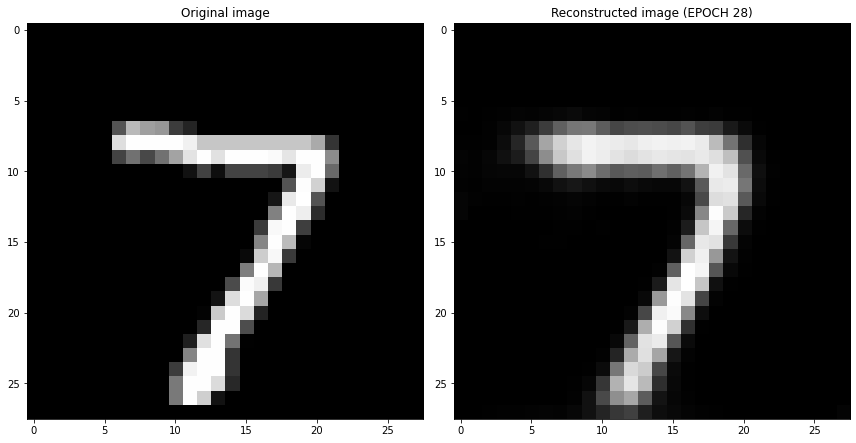

tensor([[-6.8093e-03, -1.9418e-02,  3.0018e-02,  3.4632e-03,  3.1909e-03,
         -1.5732e-03,  2.3130e-05, -1.8378e-01,  1.6263e-02, -1.8732e-03,
         -2.6468e-02, -1.0684e+00, -1.6462e-01, -1.9947e-02,  3.9068e-02,
          5.4571e-03,  1.3126e-02, -5.4753e-01,  1.5205e-02,  1.4132e-03,
         -5.9664e-04,  2.4656e-02,  5.3801e-03,  2.0725e+00,  3.1311e-02,
         -1.3118e+00,  7.3548e-03,  7.5724e-03,  4.3877e-03,  1.1673e-02,
          3.3205e-02,  1.2680e-03,  6.8206e-03, -2.5361e-03, -8.7558e-03,
          1.8349e-02, -1.0496e-03, -9.9389e-03,  7.7156e-03,  4.2330e-03,
          1.4759e-01,  9.4936e-04, -8.0289e-03, -1.9627e-02,  2.2012e-02,
         -8.1170e-03,  2.4431e-03, -6.1834e-04,  4.3775e-02,  4.5845e-01]])
tensor([[-1.6012e-02,  8.5024e-03, -6.8852e-03, -6.0509e-03, -7.3828e-03,
         -1.1859e-02,  2.6088e-04, -1.6815e+00,  2.7625e-03,  1.3068e-02,
          9.5236e-03, -2.1585e+00, -4.1820e+00, -2.0172e-03,  4.7073e-03,
         -1.3429e-03, -7.3371e-03, -

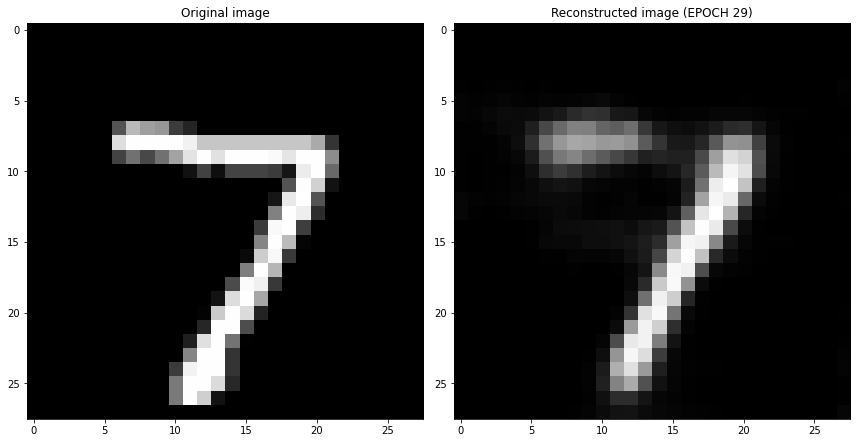

tensor([[ 1.8323e-02, -2.2330e-02,  2.6963e-02, -4.5489e-03,  9.1767e-03,
         -2.8605e-02,  1.9661e-02, -1.5104e-01,  3.0154e-02,  2.0942e-02,
          2.4746e-02, -9.6384e-01, -2.0162e-01, -2.1984e-02, -2.5023e-02,
         -2.0941e-02,  8.1848e-03, -3.8519e-01,  3.6292e-03, -3.0166e-03,
          8.9022e-03, -4.0554e-03, -2.9056e-02,  2.2091e+00, -3.1400e-02,
         -1.2924e+00,  3.0223e-02, -2.1205e-03,  2.7626e-03,  2.2186e-04,
          3.3158e-03, -2.5916e-02, -1.2331e-02, -3.0059e-02, -1.4236e-02,
          2.1054e-02,  7.2167e-03, -2.3958e-02,  2.4077e-03, -5.0521e-03,
          1.2991e-01, -4.5847e-03, -1.8134e-03, -7.0545e-03,  6.5335e-03,
          1.3108e-02,  3.3666e-03, -6.7111e-05, -9.2995e-03,  5.0689e-01]])
tensor([[ 3.2993e-03,  7.0263e-03, -6.6099e-03, -1.0677e-02,  2.5964e-03,
         -4.2001e-03, -4.1306e-03, -1.6974e+00, -3.8432e-03, -5.7198e-03,
          1.2817e-03, -2.2008e+00, -4.2569e+00, -7.0100e-03,  9.1236e-03,
          1.7199e-02,  8.3586e-03, -

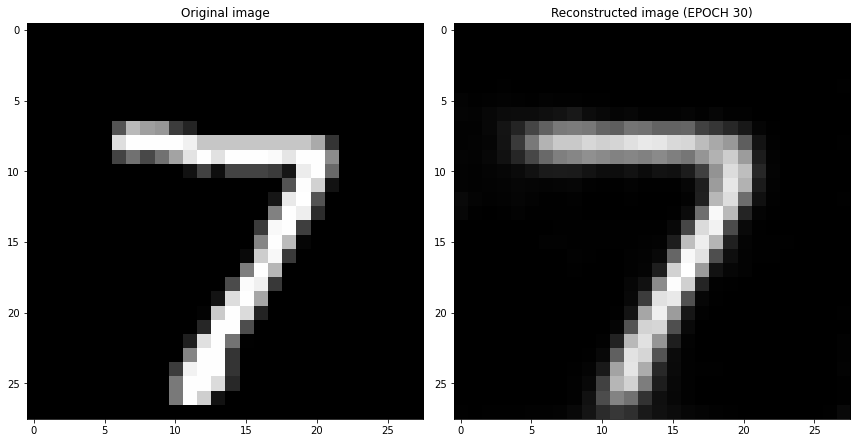

tensor([[ 2.4320e-02, -9.9905e-03, -1.2775e-03, -1.0799e-02, -3.0683e-02,
         -1.2416e-02,  1.0149e-02, -1.2207e-01,  3.5011e-02, -7.0755e-03,
          1.8526e-02, -1.0166e+00, -2.1113e-01, -1.9692e-03,  4.7482e-02,
          4.1333e-03,  1.3998e-02, -6.0854e-01,  1.9168e-02, -1.1275e-02,
          2.6141e-02, -9.6855e-03,  1.9346e-02,  2.1394e+00,  2.6774e-03,
         -1.3079e+00,  1.4066e-02,  8.3541e-03,  8.0211e-03,  1.1156e-02,
         -6.2022e-03, -6.7983e-03,  6.6964e-03, -3.8410e-03, -1.8844e-04,
          1.8668e-02, -1.3313e-02, -8.7618e-03,  4.3366e-02,  3.4027e-02,
          1.6882e-01, -2.2777e-02,  8.7219e-03, -1.5204e-02,  1.3177e-02,
          8.7449e-03,  1.5348e-04,  1.5058e-03,  2.4099e-03,  4.4704e-01]])
tensor([[-1.0265e-02, -1.1754e-02, -5.2671e-03,  8.6362e-03, -2.3010e-03,
          7.0340e-03, -9.0318e-03, -1.6808e+00, -6.1858e-03, -6.4603e-03,
         -3.2758e-03, -2.1218e+00, -4.3275e+00, -1.4989e-03,  4.6224e-03,
         -1.2899e-02, -8.1384e-03, -

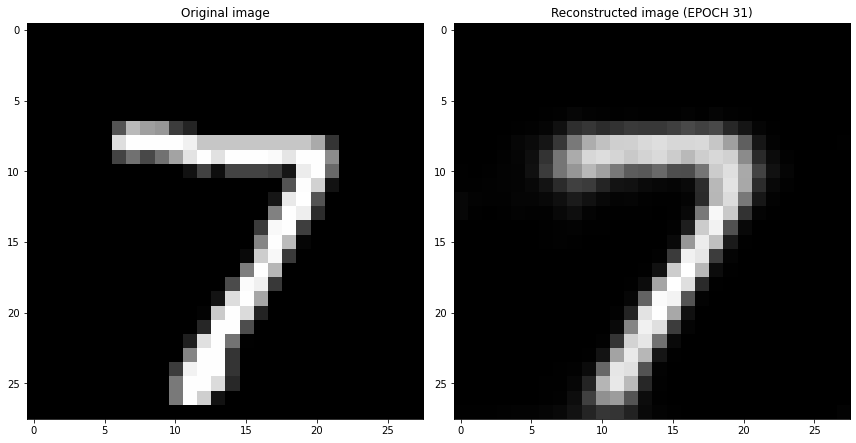

tensor([[ 1.6754e-02, -4.2249e-02,  1.5557e-02,  2.7432e-02, -2.6557e-02,
          1.0525e-04,  1.5297e-02, -5.8373e-02, -4.0812e-03,  3.8637e-02,
         -6.0055e-03, -1.0194e+00, -2.2335e-01, -2.3808e-02, -3.6107e-02,
         -3.6379e-02,  2.5796e-02, -5.2706e-01,  6.4363e-03,  4.6184e-03,
          3.3430e-02, -2.2058e-02,  3.2576e-02,  2.2044e+00,  7.0597e-03,
         -1.3307e+00, -5.8593e-03, -1.9780e-02, -6.1754e-03,  1.1596e-02,
         -7.2566e-03, -2.0074e-03,  2.9661e-05, -7.5961e-04, -8.7771e-03,
         -3.1990e-02, -3.5596e-03, -5.1887e-03, -1.1853e-02, -2.4576e-02,
          1.3560e-01, -2.2023e-02,  2.8726e-02, -7.3713e-03,  2.0873e-02,
          2.1638e-02, -1.0713e-02,  2.2675e-02, -9.0358e-03,  5.1869e-01]])
tensor([[-1.8728e-02, -1.7661e-02, -2.1125e-03, -4.5796e-04, -6.5082e-04,
         -8.4939e-03, -1.1364e-02, -1.6738e+00,  2.1178e-02, -6.7917e-04,
          9.3652e-03, -2.2231e+00, -4.1476e+00, -3.6001e-03, -1.3476e-03,
         -1.0434e-02,  8.2460e-04, -

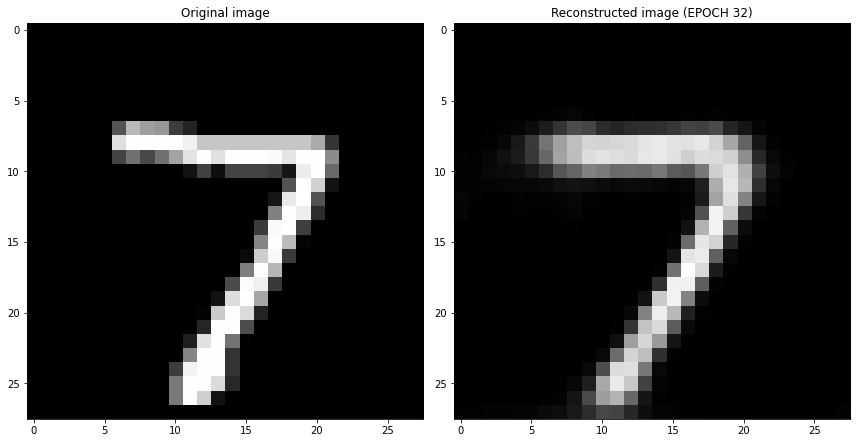

tensor([[ 1.5976e-02,  1.0130e-02,  9.6794e-03,  1.9401e-02, -5.7089e-03,
          4.0542e-03, -9.4181e-03, -7.8902e-02,  6.2593e-03,  2.7363e-02,
         -2.4883e-03, -9.5130e-01, -2.2982e-01,  7.9852e-03,  2.7124e-02,
         -7.3960e-03,  4.5356e-03, -5.6067e-01, -3.5302e-03, -1.4843e-02,
          4.7550e-03, -1.7674e-02, -2.5721e-02,  2.0356e+00, -1.0193e-02,
         -1.3030e+00,  1.8439e-02,  1.4234e-02,  1.0613e-03,  4.0630e-03,
         -1.1481e-02,  2.1597e-02, -1.1301e-02,  9.3684e-03, -1.5291e-02,
         -1.0966e-02, -1.7798e-02,  9.4063e-03,  5.4762e-04, -6.3892e-03,
          1.9466e-01, -1.2675e-02, -1.3571e-02,  4.1104e-03,  2.3612e-02,
         -1.9838e-03,  1.0275e-02, -1.8685e-02, -2.9217e-03,  4.8711e-01]])
tensor([[ 7.1077e-03,  8.3390e-04, -3.8191e-03,  3.9388e-03, -1.5178e-02,
          3.3021e-03,  5.9646e-03, -1.6684e+00,  2.8123e-03,  2.3927e-03,
         -6.9281e-03, -2.0882e+00, -4.1309e+00, -5.0126e-03, -1.0832e-02,
         -1.8690e-03,  1.0038e-03, -

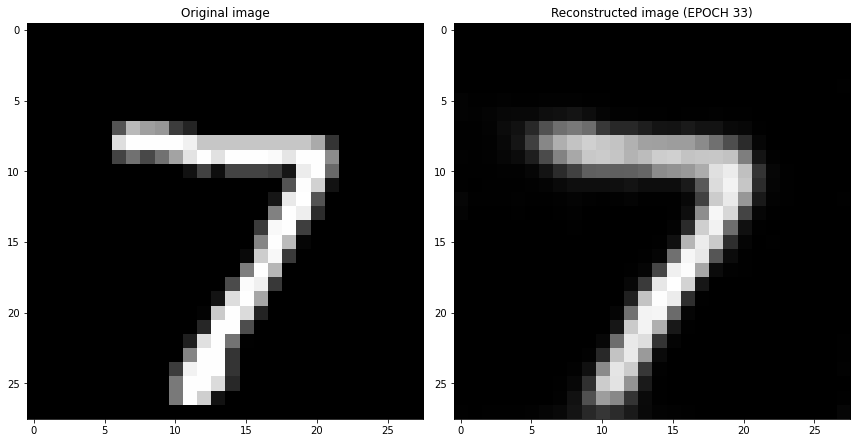

tensor([[ 1.2680e-02, -1.0163e-02,  2.3713e-02, -8.9872e-03, -3.0146e-02,
         -1.6066e-03,  2.6181e-02, -1.5161e-01,  2.5811e-02,  2.0893e-02,
         -1.6847e-02, -1.0444e+00, -2.1034e-01, -3.3498e-02,  3.2752e-02,
         -2.1457e-02, -1.3971e-02, -5.3237e-01,  4.1100e-03, -1.8244e-02,
         -2.0903e-02, -3.0101e-02,  1.6214e-02,  2.2177e+00, -1.1735e-02,
         -1.3403e+00,  1.7870e-02,  1.5969e-03,  4.1243e-03,  5.3545e-03,
         -7.2429e-03, -6.1855e-03, -3.5206e-02, -1.3440e-02,  1.0485e-02,
          4.9324e-03, -1.6063e-02, -1.0863e-02,  1.0080e-02,  1.3002e-02,
          1.3222e-01, -9.2323e-03, -2.8263e-02, -5.5334e-03,  2.7451e-02,
          2.7394e-03, -6.9090e-03, -2.5791e-02, -1.2554e-02,  5.7576e-01]])
tensor([[-3.2426e-03, -6.1710e-03, -6.6823e-03, -2.8064e-02,  9.8053e-03,
         -1.1856e-02,  2.3664e-03, -1.7601e+00, -5.9600e-03, -9.2144e-03,
          5.8362e-03, -2.3209e+00, -4.1039e+00,  2.9490e-03, -2.0688e-03,
          1.9181e-03, -1.1610e-03, -

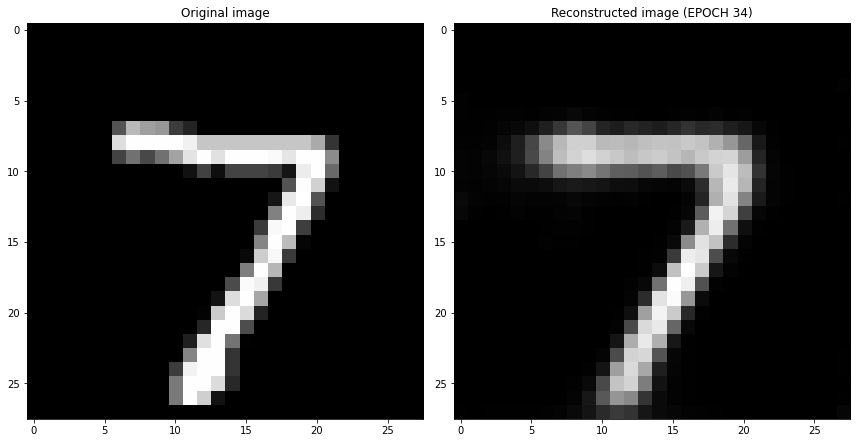

tensor([[ 2.9465e-03, -1.4606e-02,  7.3077e-03,  6.6429e-03,  1.0374e-02,
         -5.4239e-02, -8.6856e-03, -1.6761e-01, -2.0695e-02,  1.2435e-02,
         -1.3453e-02, -1.0532e+00, -1.9450e-01,  2.8627e-02,  1.5670e-02,
         -1.1435e-03, -8.2452e-03, -5.1225e-01,  1.7439e-02, -2.5857e-02,
          3.8606e-02, -3.8066e-02, -9.2587e-03,  2.0712e+00,  1.9609e-02,
         -1.3595e+00, -1.2297e-05, -1.3946e-02,  9.3364e-03,  1.3251e-02,
         -2.6102e-02,  1.7452e-02,  5.0534e-03, -8.0875e-03,  4.0747e-02,
          1.0148e-02,  1.8955e-02, -3.6908e-02,  8.5675e-03, -7.8744e-03,
          1.2348e-01, -2.3802e-02,  1.6228e-02, -3.4158e-02,  1.2359e-02,
          3.7896e-03, -2.8471e-03,  2.2936e-02, -1.7819e-02,  5.9377e-01]])
tensor([[-3.7434e-03, -6.9964e-03, -1.4623e-02, -3.5091e-03,  2.4040e-03,
         -1.3554e-02,  1.6866e-02, -1.6828e+00,  6.1964e-03, -2.5492e-04,
          3.4805e-04, -2.2020e+00, -4.2637e+00,  1.7252e-03, -1.2596e-03,
          1.2399e-02, -1.4729e-02, -

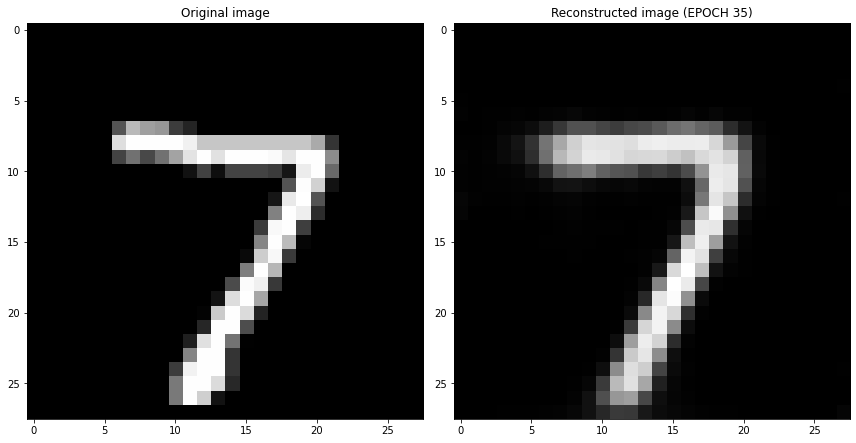

tensor([[-8.6965e-03, -7.0208e-03, -6.1955e-04,  1.1860e-02,  2.7776e-02,
          4.0139e-02, -1.1754e-02, -1.9948e-01, -2.6814e-04,  3.0807e-02,
          6.1745e-03, -9.8866e-01, -2.2138e-01, -1.6932e-04,  2.0212e-02,
          9.3713e-03,  3.7025e-03, -5.2162e-01,  4.3273e-03, -2.5379e-02,
          2.4082e-02, -1.3449e-03,  4.2720e-03,  2.0766e+00, -8.4845e-03,
         -1.3689e+00,  1.4733e-02, -1.4905e-03, -4.1482e-03,  4.6508e-03,
          3.3245e-03, -5.8279e-03,  3.5829e-03, -1.1905e-02,  1.1970e-02,
          2.9615e-04,  3.2186e-02, -2.5508e-02, -1.9709e-02,  1.4275e-02,
          1.4526e-01, -4.0713e-02,  1.5832e-02, -1.7118e-02,  1.6614e-02,
         -2.2828e-02,  1.2267e-02, -2.9183e-03,  1.6773e-02,  5.0527e-01]])
tensor([[-1.0877e-02, -4.6471e-03, -3.8571e-03, -9.5442e-03, -7.8741e-03,
         -3.6064e-03,  4.8160e-03, -1.7271e+00, -5.0457e-03, -6.4902e-03,
         -1.0860e-02, -2.2128e+00, -3.9214e+00, -2.7481e-03, -7.4467e-03,
         -5.1702e-04, -8.9807e-03, -

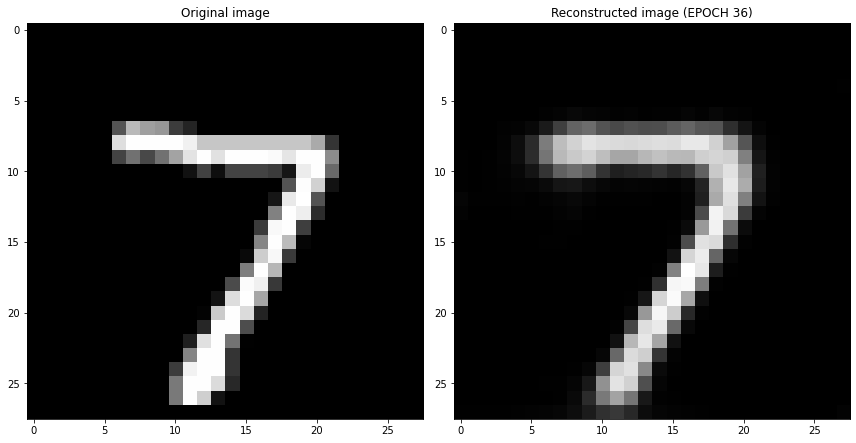

tensor([[-5.1904e-03,  4.7466e-03, -2.9215e-03, -5.1549e-03, -1.6848e-02,
          9.5869e-03, -8.4554e-03, -2.2801e-01, -3.9007e-02,  1.1869e-02,
          1.5651e-02, -1.0335e+00, -1.8438e-01,  6.1140e-03,  7.5895e-03,
          3.7923e-02,  1.2231e-02, -5.7050e-01,  1.0505e-02,  1.8086e-02,
          3.4856e-02, -1.1826e-02,  4.3827e-03,  2.0608e+00,  1.0195e-02,
         -1.2669e+00,  3.9027e-02,  2.1172e-02,  1.1095e-02,  6.7206e-03,
         -1.3485e-02, -2.2887e-02,  1.4193e-02,  1.3095e-02,  1.6942e-02,
          6.1901e-03,  1.4253e-02, -3.1645e-02,  6.2357e-03, -2.2682e-02,
          1.2933e-01,  2.5680e-03,  2.8689e-02,  2.5694e-03, -1.0320e-02,
         -9.5536e-04, -2.2066e-02, -2.3201e-02,  1.5325e-02,  5.5968e-01]])
tensor([[-6.8872e-03, -6.7613e-03,  4.5294e-03, -5.3922e-03, -6.2017e-03,
         -2.2843e-03, -1.5104e-02, -1.7724e+00,  4.0409e-03, -2.1982e-03,
          3.8962e-03, -2.2248e+00, -4.1626e+00,  3.1077e-03, -2.3762e-03,
          4.8493e-03, -2.2068e-03, -

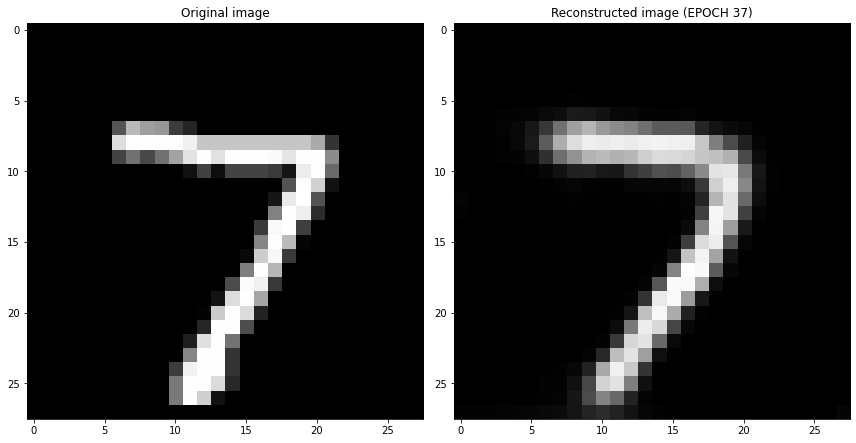

tensor([[-1.4450e-02, -1.2371e-02,  2.8440e-03, -1.4605e-02,  6.5398e-03,
          1.0947e-02,  3.3606e-02, -3.3507e-01, -1.2477e-02, -1.7341e-02,
          9.7920e-03, -1.0134e+00, -1.9346e-01, -2.7603e-03,  2.6705e-02,
         -7.8663e-03,  1.7138e-02, -5.2792e-01, -1.8307e-02,  1.0401e-02,
          1.4277e-02, -3.2022e-02,  9.5071e-03,  2.1345e+00, -1.4691e-02,
         -1.3637e+00,  1.5902e-02,  2.6330e-03, -9.8539e-04,  3.0917e-02,
          1.9723e-02, -1.5871e-02, -9.8505e-03, -1.6783e-03,  2.2549e-02,
         -1.1158e-02, -2.7887e-03, -1.6105e-02,  1.6573e-02, -8.8167e-03,
          2.0902e-01, -1.7947e-03,  2.2125e-02, -1.1837e-02, -1.2849e-02,
          8.4974e-03, -1.6752e-02,  1.7701e-02, -2.5678e-03,  5.3288e-01]])
tensor([[-1.0274e-02, -4.5712e-04, -6.6095e-03, -1.5050e-02, -1.2217e-02,
         -1.3402e-02, -2.7982e-02, -1.7040e+00, -6.1594e-03, -9.1282e-03,
         -1.6010e-03, -2.1994e+00, -4.2012e+00,  3.4793e-03, -2.4487e-02,
          5.7805e-03,  1.3298e-03, -

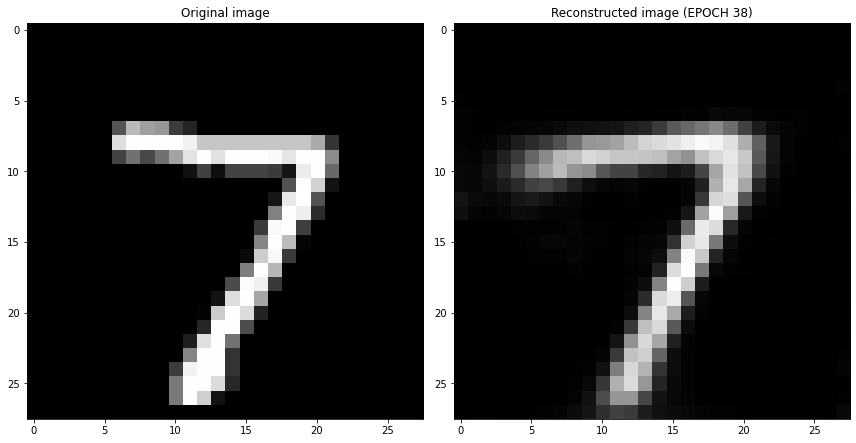

tensor([[-4.3126e-02,  9.6624e-03, -8.0113e-03, -5.6770e-03, -3.7715e-03,
         -2.7876e-02,  1.8380e-02, -2.9633e-01, -2.8650e-03,  9.3074e-03,
          2.0986e-02, -1.0023e+00, -1.4448e-01, -1.9893e-03,  2.5314e-02,
         -2.1796e-03,  9.5077e-04, -6.2117e-01, -2.3140e-02,  1.8792e-02,
          2.0053e-02,  8.7466e-03, -1.8372e-02,  2.1662e+00, -7.4182e-03,
         -1.3676e+00, -3.9355e-02, -1.8031e-03, -2.0689e-03,  1.5158e-02,
         -1.2312e-02, -2.6971e-02,  4.7473e-03, -2.9119e-03, -9.3926e-04,
          3.8206e-02, -1.1212e-02, -3.9622e-02,  9.7001e-03, -6.2042e-03,
          1.0284e-01,  1.2144e-02, -3.4048e-02, -1.4028e-02,  7.4124e-03,
         -1.3350e-02, -2.7421e-04,  4.9846e-03,  1.1517e-02,  6.5328e-01]])
tensor([[-1.9872e-02,  1.2269e-02, -8.5434e-03, -2.4014e-03,  7.3469e-03,
         -4.6980e-03, -6.3462e-03, -1.7480e+00, -1.6829e-02, -5.2983e-05,
          1.2722e-03, -2.3070e+00, -4.2143e+00, -9.0262e-03, -1.7344e-03,
          1.2427e-02, -5.9448e-03, -

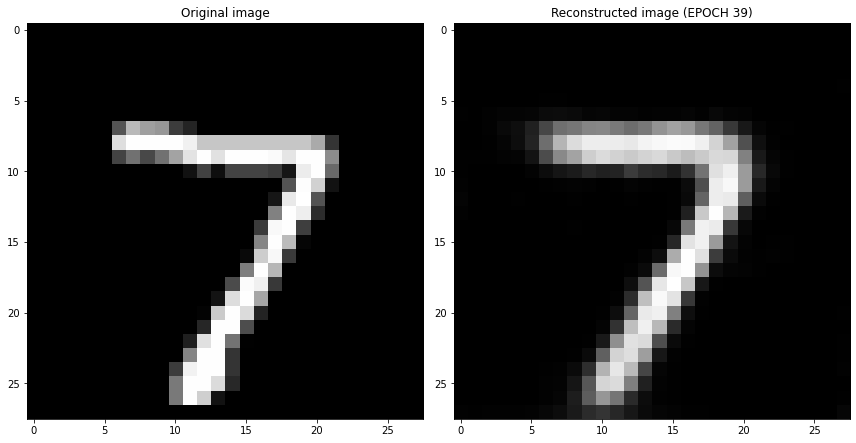

tensor([[ 1.4636e-02, -1.2914e-02, -3.6697e-03,  1.2100e-04, -1.1993e-02,
          2.5451e-02,  1.0424e-02, -1.8202e-01, -1.3287e-02,  8.6021e-03,
         -3.2590e-02, -1.1791e+00, -2.0621e-01, -7.2393e-03, -9.4889e-03,
          5.4580e-03, -6.4544e-03, -5.7619e-01, -1.2989e-02,  6.8480e-03,
          7.5974e-03,  2.6192e-02, -5.5390e-03,  2.1349e+00,  2.5773e-03,
         -1.3709e+00,  8.4929e-03, -1.9574e-02, -4.6843e-03,  7.4222e-03,
         -1.5783e-02, -1.6261e-02,  6.7087e-03,  2.1955e-03,  5.5080e-03,
          2.0223e-02,  2.4921e-03,  3.5924e-03, -1.4112e-02,  6.4309e-03,
          1.1823e-01,  2.5215e-02,  3.7179e-03, -6.7591e-03, -2.1857e-02,
         -1.3481e-02,  3.6170e-03,  7.2056e-03,  3.4097e-03,  5.1214e-01]])
tensor([[ 9.6703e-03, -1.7378e-03,  1.1325e-03, -2.3272e-04, -5.8693e-03,
         -4.4717e-03, -2.7358e-03, -1.8225e+00,  6.1953e-04,  5.6038e-03,
         -1.1409e-02, -2.3240e+00, -4.2615e+00, -2.7460e-03, -6.4387e-04,
         -1.0498e-02, -4.2046e-03, -

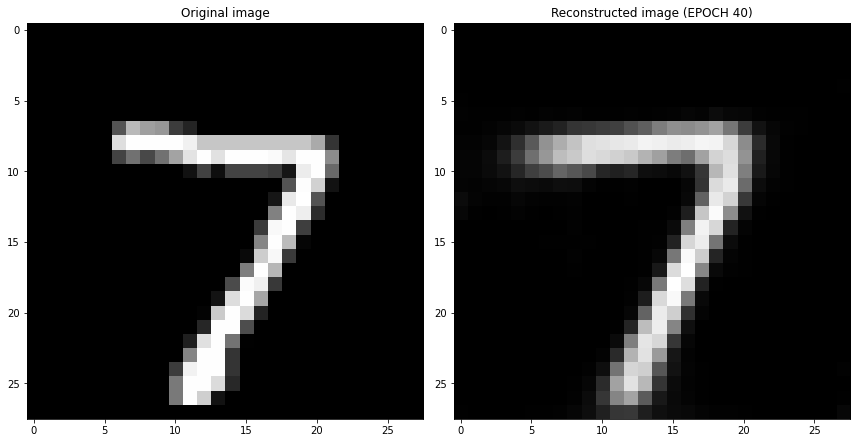

tensor([[-8.0019e-03,  2.0999e-03, -2.6185e-02, -1.0131e-02, -5.7504e-03,
          7.2511e-03,  5.4586e-03, -3.2068e-01,  6.7179e-03,  4.4273e-04,
          1.0772e-02, -1.1365e+00, -1.5973e-01, -2.7077e-02, -1.8077e-04,
         -1.7693e-02,  2.8642e-02, -5.8379e-01,  1.3912e-02, -1.4148e-02,
         -2.2565e-03,  5.5596e-03,  1.3323e-02,  2.1810e+00, -3.5583e-03,
         -1.3313e+00,  1.0756e-02,  1.2311e-03,  3.7127e-03,  1.6619e-02,
          2.8420e-02, -2.3732e-02, -2.0284e-02,  6.9614e-03, -3.1183e-02,
          2.6285e-02,  6.2529e-03, -9.9318e-03,  1.5149e-02,  2.6199e-02,
          6.3032e-02,  9.5100e-03, -2.8206e-03, -1.2474e-02, -4.1074e-03,
         -2.5949e-02,  1.7149e-02,  1.0132e-02,  5.2389e-03,  6.4372e-01]])
tensor([[ 8.7401e-03, -3.3653e-03, -1.2730e-02, -5.4867e-03, -1.0974e-02,
          7.3391e-04, -1.0291e-02, -1.7650e+00,  1.3927e-03,  4.3028e-03,
          8.5873e-04, -2.3232e+00, -4.3057e+00, -1.8051e-02, -5.4585e-03,
         -1.2992e-02, -5.8707e-03, -

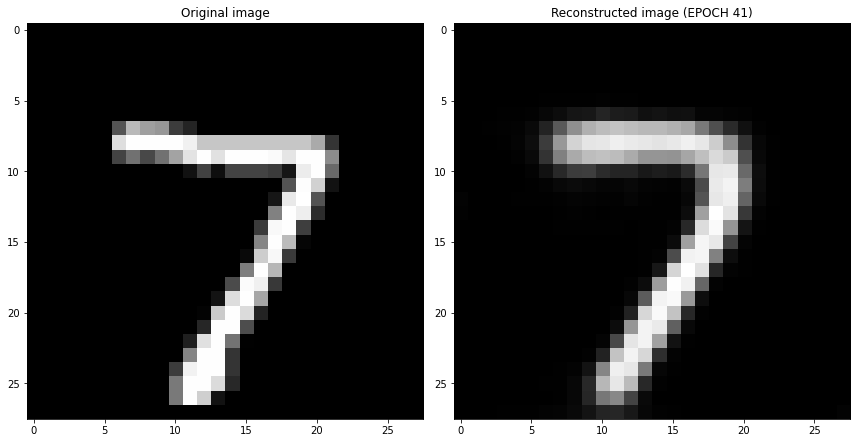

tensor([[ 4.2751e-03,  1.0678e-04, -5.3532e-03,  1.5668e-02, -1.2012e-02,
         -1.4249e-02,  1.0038e-02, -1.8494e-01, -1.6724e-03, -6.9300e-03,
          3.2029e-02, -1.0797e+00, -1.9655e-01,  7.7947e-03, -1.4434e-02,
         -8.6293e-03,  5.9399e-03, -5.8552e-01, -1.9774e-03,  7.9605e-03,
         -3.3492e-03,  8.4505e-03,  1.4725e-03,  2.0632e+00,  7.2714e-03,
         -1.3599e+00,  1.6160e-02, -1.6491e-02,  2.0534e-02,  4.0114e-02,
          9.9317e-03,  2.1625e-02,  2.0965e-02, -2.4653e-02, -2.5087e-02,
          1.8934e-02, -3.6062e-04,  1.6703e-02, -9.1587e-03,  2.2158e-02,
          1.3450e-01,  1.4768e-02, -1.1372e-02,  1.4902e-02, -2.5806e-02,
          8.5115e-03, -8.3372e-03,  3.4139e-02, -3.9510e-02,  5.9058e-01]])
tensor([[ 6.6747e-03, -8.9351e-03, -6.9485e-03,  7.2630e-03,  2.7037e-03,
          2.3439e-03, -1.1923e-04, -1.7831e+00,  7.7926e-03,  4.0534e-04,
         -1.6486e-02, -2.3086e+00, -4.2704e+00,  3.9509e-04, -3.1986e-03,
          1.0165e-03,  1.2622e-02, -

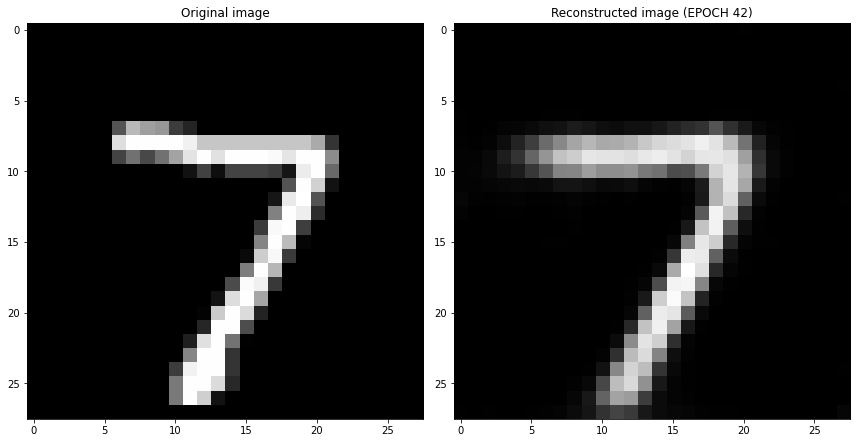

tensor([[ 6.6117e-03, -1.3778e-02,  6.8366e-03, -1.6039e-02, -1.3877e-02,
         -5.7694e-03,  4.3801e-03, -1.6687e-01,  3.6707e-02,  9.2148e-03,
          2.3565e-02, -1.0564e+00, -1.6367e-01, -7.3680e-03,  1.5571e-02,
          5.0230e-03, -1.4404e-02, -5.1534e-01, -2.4799e-03,  2.0722e-02,
         -1.0278e-02,  8.3405e-03, -1.9040e-03,  2.0692e+00,  1.6429e-02,
         -1.3415e+00,  1.4973e-02,  6.1671e-03,  6.4306e-03, -3.9559e-03,
          1.3200e-02,  2.0020e-02,  9.2234e-03, -3.3628e-02,  2.0245e-02,
         -2.1505e-03,  1.4930e-02,  1.1394e-02,  2.8306e-03,  1.4448e-02,
          1.2027e-01, -9.4641e-03,  6.3674e-03, -1.7389e-02, -1.3497e-02,
         -4.1061e-03,  8.7291e-04, -1.0669e-02, -2.8262e-02,  6.7559e-01]])
tensor([[ 1.2753e-02,  3.3492e-03, -1.2481e-02,  4.3297e-03,  1.2210e-02,
          4.1626e-03,  2.7195e-03, -1.7255e+00, -1.5608e-02, -1.3371e-02,
          1.0021e-02, -2.2993e+00, -4.1957e+00, -1.2156e-02, -1.3693e-02,
         -3.2339e-03, -4.5162e-03, -

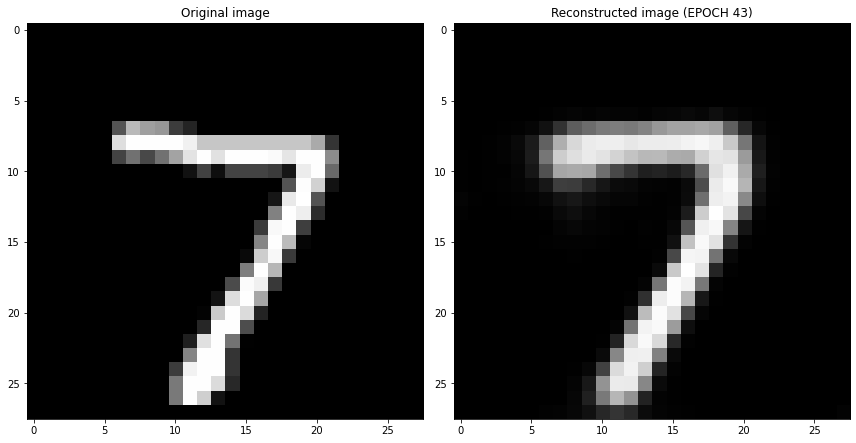

tensor([[ 1.3284e-03, -1.3064e-02,  3.1101e-02,  3.5875e-03,  1.3193e-03,
         -7.1471e-03,  4.3990e-03, -3.1276e-01, -2.7195e-02,  3.5169e-03,
          1.5329e-02, -1.0804e+00, -1.2303e-01,  2.8250e-02,  1.4200e-02,
          2.3394e-03,  1.2348e-02, -5.4951e-01,  2.0143e-02,  1.2203e-02,
         -1.0077e-03,  1.7974e-02, -2.4623e-02,  2.0267e+00, -1.0766e-02,
         -1.4326e+00, -3.2148e-03,  4.4677e-04, -4.6648e-03,  3.9184e-02,
          2.2008e-02, -1.0387e-02,  2.5674e-02, -7.4731e-03,  4.2125e-02,
          2.5415e-02,  4.0745e-03,  1.0350e-02, -1.7902e-02, -2.6374e-03,
          1.1784e-01, -7.3343e-03,  1.1027e-02, -2.7556e-02, -2.7654e-02,
         -4.9662e-03, -1.9120e-02,  2.1805e-02, -1.6043e-02,  6.2689e-01]])
tensor([[-1.0595e-02, -5.5760e-03, -1.8432e-02,  1.5211e-03, -1.7928e-03,
          1.2647e-02,  6.9576e-03, -1.7041e+00,  6.7513e-03,  1.4750e-03,
         -3.3634e-03, -2.2736e+00, -4.1358e+00, -8.2344e-03, -1.3724e-02,
          8.4274e-03,  6.9969e-03, -

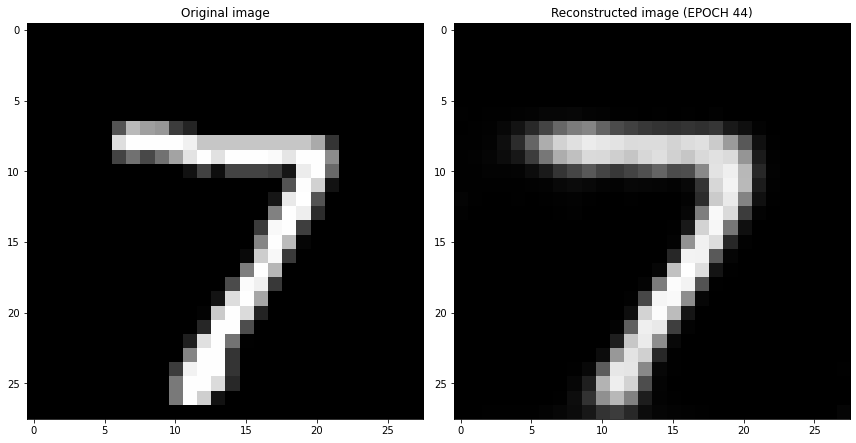

tensor([[-1.1958e-02, -1.6626e-02,  1.5534e-02, -1.9771e-02,  2.6476e-02,
         -8.8598e-04, -2.4246e-03, -2.4646e-01, -3.1290e-03,  4.7847e-03,
          5.9523e-02, -1.1890e+00, -1.4153e-01,  4.2177e-03,  1.1454e-02,
          1.7362e-02, -7.9793e-03, -6.2891e-01, -3.6513e-03, -4.1311e-02,
          5.7434e-03, -2.5467e-02, -1.5878e-02,  2.0724e+00, -5.6055e-03,
         -1.3843e+00,  1.2341e-02,  1.4556e-02, -4.2151e-03, -1.3909e-02,
          1.1199e-02, -1.5454e-02, -1.7613e-02,  1.1327e-02,  2.2559e-02,
         -1.0675e-02,  2.8057e-03, -1.0875e-02,  1.4334e-02,  7.8110e-03,
          1.4153e-01, -2.5801e-02,  1.2007e-02, -3.0956e-03, -1.1157e-02,
         -8.0413e-03, -5.9174e-03,  1.3962e-02,  4.4921e-03,  6.9435e-01]])
tensor([[-1.3326e-02,  4.8476e-03,  9.9457e-04, -3.2182e-04, -2.5001e-02,
         -6.7899e-03, -8.0676e-03, -1.7147e+00, -4.8752e-03,  1.3612e-03,
         -1.3549e-02, -2.1911e+00, -4.1219e+00, -3.4461e-03, -7.8745e-03,
          4.4330e-03, -9.1182e-03, -

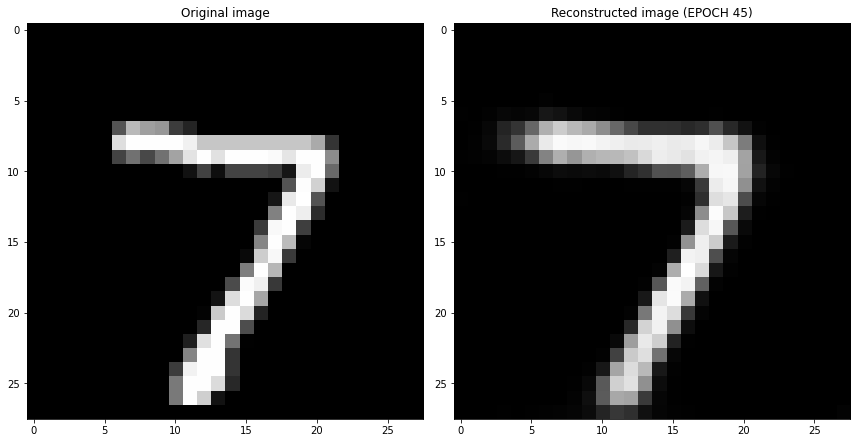

tensor([[-2.1494e-02, -5.5429e-03,  4.8426e-03, -1.7733e-02, -3.9739e-03,
          1.1583e-02,  2.6109e-02, -3.0732e-01, -1.8886e-03,  1.4490e-03,
         -1.2137e-02, -1.0808e+00, -1.5662e-01, -2.3018e-03,  1.9696e-02,
          8.1994e-03,  2.4518e-02, -5.8945e-01,  2.8398e-03,  6.7422e-03,
          1.6440e-02,  6.2616e-03, -2.1748e-02,  1.9483e+00, -2.0235e-02,
         -1.3457e+00,  1.4946e-02, -1.6169e-02, -1.6164e-02, -2.6570e-02,
         -9.1560e-03, -1.5267e-02, -3.9446e-03,  1.6516e-03,  4.0825e-03,
         -1.5201e-02, -1.7353e-02,  1.8581e-02,  7.4080e-03, -1.3340e-03,
          1.9018e-01,  9.0916e-03, -5.6725e-03, -8.7203e-03,  1.1991e-03,
          2.1405e-02,  9.3422e-03,  1.2577e-02, -5.4635e-03,  6.4285e-01]])
tensor([[ 7.5540e-04, -1.4255e-03, -3.9507e-03, -1.6665e-02, -1.1534e-02,
          2.3701e-03, -9.0941e-03, -1.6877e+00, -4.4199e-03, -4.4823e-04,
         -1.3175e-02, -2.1939e+00, -4.1605e+00, -1.5110e-02, -5.5056e-03,
          3.4913e-03, -5.4109e-03, -

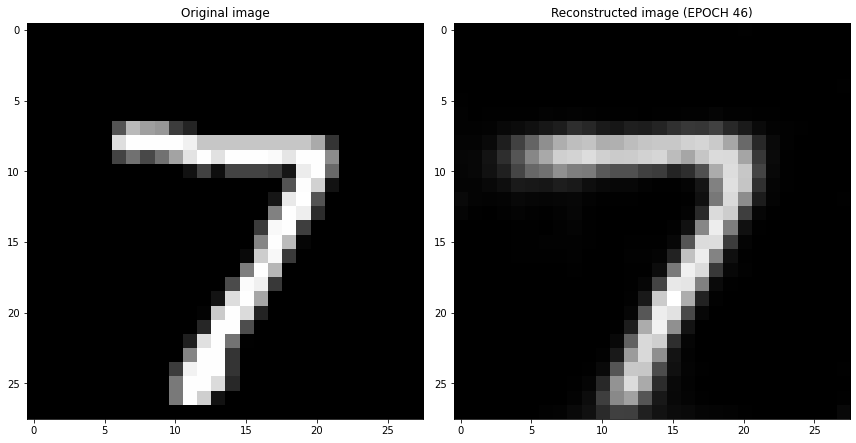

tensor([[ 1.0461e-02, -8.6717e-04, -1.7322e-02,  1.6417e-02,  8.1981e-03,
          2.3918e-03,  8.6650e-03, -3.1305e-01, -5.5103e-03,  1.0538e-02,
         -1.4234e-02, -1.1125e+00, -1.7603e-01,  1.1261e-02, -1.3930e-02,
         -9.4325e-03,  7.9488e-03, -7.3977e-01, -1.7813e-03, -7.4533e-03,
         -1.7250e-03,  6.2643e-03,  7.8994e-04,  2.0078e+00, -1.4898e-02,
         -1.3623e+00, -9.0735e-03, -1.3206e-02, -2.5054e-03, -3.4439e-03,
          4.9484e-03, -1.9504e-03, -3.4488e-02, -2.8800e-02, -8.2279e-03,
         -1.8967e-02, -1.5110e-03,  5.6973e-03,  4.4935e-03,  1.3599e-02,
          1.0678e-01, -5.3681e-03, -2.2363e-03,  1.1703e-02,  1.3817e-02,
          3.1306e-03,  1.3643e-02,  3.9907e-03, -1.5815e-02,  6.1337e-01]])
tensor([[-5.5007e-03, -9.9889e-03,  7.4537e-03,  2.1994e-03, -1.6443e-03,
          2.3976e-03,  9.8690e-03, -1.6729e+00, -7.4437e-03, -1.4569e-02,
         -6.0565e-03, -2.2706e+00, -4.4451e+00,  1.3581e-03, -4.1048e-04,
         -3.7838e-03, -5.2904e-03, -

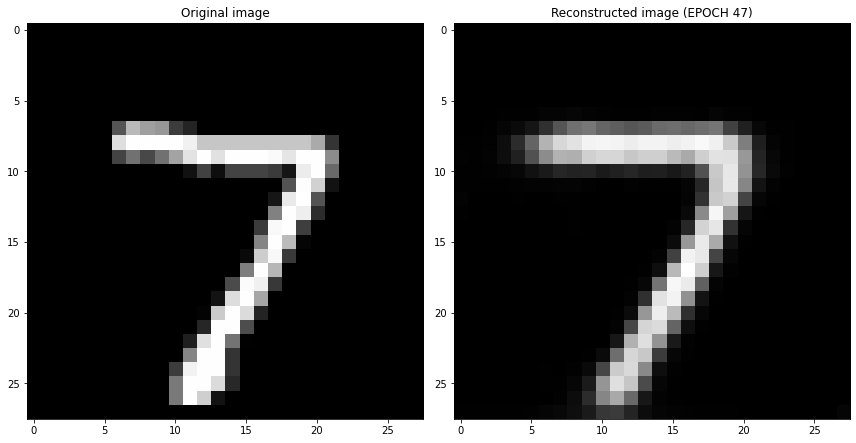

tensor([[-1.3129e-02,  3.4106e-03, -2.2604e-03, -1.9047e-02, -1.3264e-02,
         -1.0478e-02,  3.6999e-02, -3.1827e-01, -1.8854e-03, -1.8873e-02,
          4.1495e-04, -1.1449e+00, -1.3435e-01,  1.6085e-02, -1.8865e-02,
         -1.4072e-02,  9.3635e-03, -6.3140e-01,  3.5230e-02, -7.2944e-03,
         -3.0722e-03,  5.6354e-03, -5.0694e-03,  1.9096e+00, -1.1441e-03,
         -1.3883e+00, -1.5046e-03, -7.5680e-03,  5.3710e-03,  1.8113e-02,
          1.3371e-02,  1.2125e-02, -1.3173e-02, -4.4667e-02,  2.0369e-02,
         -1.5865e-02, -1.4923e-02,  2.0582e-02,  1.1380e-02, -4.7053e-03,
          1.5011e-01, -1.7036e-02,  7.3688e-03, -1.8386e-02, -3.1333e-03,
          3.1301e-03, -5.3172e-03,  5.7534e-03,  1.6862e-02,  6.2243e-01]])
tensor([[-1.1295e-02, -1.6637e-04, -5.9833e-03,  2.5815e-03, -4.4517e-03,
          6.0791e-04, -1.7336e-02, -1.5874e+00, -1.6879e-02,  2.2556e-04,
          3.8464e-03, -2.2105e+00, -4.1565e+00, -8.4513e-03,  2.5296e-03,
         -3.0548e-03,  6.9175e-03, -

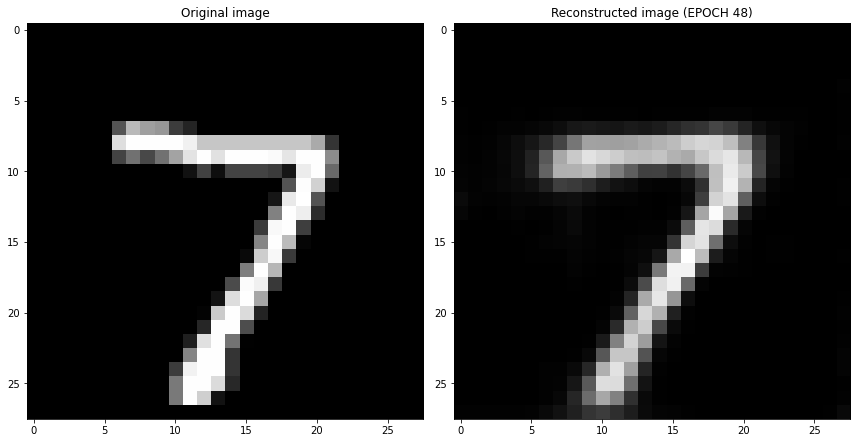

tensor([[ 9.0086e-03,  1.2037e-02,  1.2873e-02,  1.3762e-02,  1.9190e-02,
          3.6690e-02,  1.3363e-03, -3.0356e-01, -3.0142e-02, -1.8585e-02,
          4.0727e-02, -1.1816e+00, -9.2052e-02, -3.3845e-03,  8.0926e-03,
         -1.6606e-02, -1.1581e-03, -7.1761e-01, -5.3266e-03,  2.0956e-02,
         -1.0471e-02, -3.3796e-02, -1.4933e-03,  1.9264e+00,  1.1789e-02,
         -1.4303e+00,  1.5834e-03,  2.6693e-02,  6.7050e-03,  8.2588e-03,
         -6.9099e-03, -3.5166e-03,  1.9072e-03, -1.1639e-02,  9.1330e-03,
         -2.3379e-02,  1.4436e-02,  1.1532e-02, -1.0133e-02,  1.3414e-02,
          1.2784e-01, -3.8502e-03,  7.9771e-03,  2.3361e-02, -4.1019e-02,
          3.0293e-02, -7.0379e-03, -5.9990e-03,  8.0566e-03,  6.4072e-01]])
tensor([[ 1.2258e-03, -6.9969e-04,  4.4676e-03, -2.4522e-03,  1.1210e-03,
         -3.9359e-03,  4.5285e-03, -1.7029e+00, -8.6207e-03,  1.2106e-03,
         -6.8812e-03, -2.1417e+00, -4.2459e+00, -3.8397e-03,  2.1384e-03,
         -3.1694e-03,  3.3243e-03, -

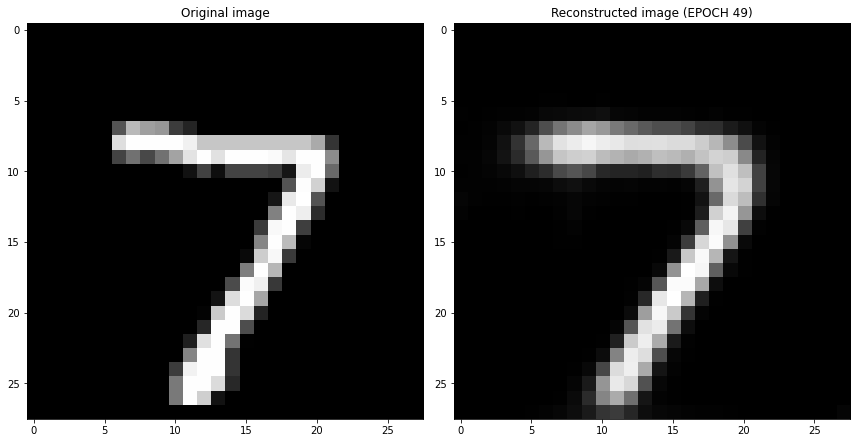

tensor([[ 3.9872e-03,  2.9397e-02, -1.2548e-02, -3.7174e-04, -1.8135e-03,
         -1.0424e-02, -1.2503e-02, -2.9663e-01,  2.4451e-02,  2.1496e-02,
          1.7590e-02, -1.2011e+00, -7.0816e-02, -1.3627e-02, -1.8096e-02,
          1.3546e-02,  9.8918e-03, -6.0844e-01, -6.2288e-03, -1.6720e-02,
         -1.3860e-02,  1.9211e-02,  1.6243e-03,  1.9017e+00, -1.3159e-02,
         -1.4611e+00,  2.8965e-02,  1.2624e-02,  8.4755e-03, -1.3914e-02,
         -4.9449e-03,  1.3318e-03,  1.2278e-02, -2.5123e-02, -5.8236e-03,
         -2.0949e-03,  1.1820e-02, -2.0518e-02, -2.0443e-02, -1.7905e-03,
          7.7121e-02,  7.4130e-03,  1.2831e-02, -2.3313e-02, -8.0802e-03,
         -4.1330e-02, -7.9616e-03, -3.1921e-02, -2.9486e-03,  7.0213e-01]])
tensor([[ 5.8783e-03,  5.9780e-03, -1.5209e-02, -2.4634e-02,  2.5769e-03,
          6.9438e-03, -1.5471e-03, -1.7004e+00,  4.4952e-03, -1.3985e-03,
          7.1439e-03, -2.2819e+00, -4.3060e+00, -2.8573e-03, -9.0838e-04,
         -6.2893e-03,  1.0906e-02, -

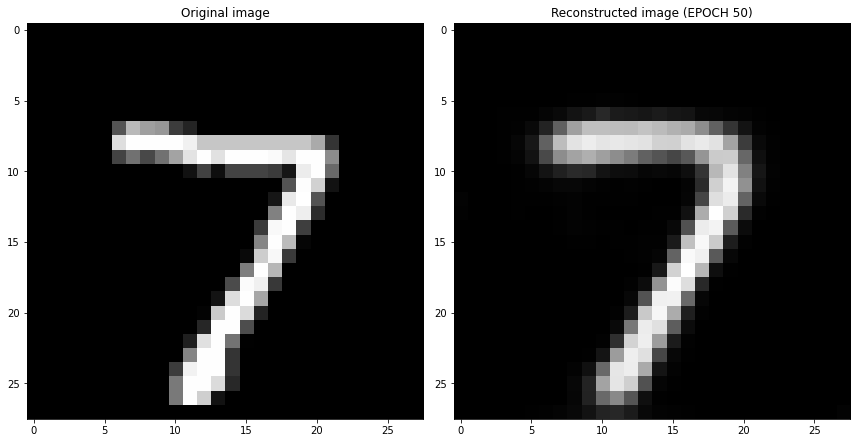

In [10]:
### Training loop with progress bar

num_epochs = 50
beta = 1

train_div_loss = []
train_rec_loss = []
val_div_loss = []
val_rec_loss = []

pbar = tqdm_notebook(range(num_epochs))

for epoch_num in pbar:
   
    # Train an epoch and save losses
    train_epoch_loss = train_epoch(net, device, train_dataloader, beta, loss_function, optimizer_1)
    # Validate an epoch
    val_epoch_loss = val_epoch(net,  device, val_dataloader, loss_function)
    # Compute averages over an epoch
    mean_train_div_loss = np.mean(train_epoch_loss[0])
    mean_train_rec_loss = np.mean(train_epoch_loss[1])
    mean_val_div_loss = np.mean(val_epoch_loss[0])
    mean_val_rec_loss = np.mean(val_epoch_loss[1])
    # Append to plot
    train_div_loss.append(mean_train_div_loss)
    train_rec_loss.append(mean_train_rec_loss)
    val_div_loss.append(mean_val_div_loss)
    val_rec_loss.append(mean_val_rec_loss)
    pbar.set_description("Div loss: %s" %round(mean_train_div_loss,3)+","+"Rec loss %s" %round(mean_train_rec_loss,3)+","+"Train loss %s" %round(mean_train_div_loss+mean_train_rec_loss,3))
    
    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_data[0][0].unsqueeze(0).to(device)
    net.eval()
    with torch.no_grad():
        # Encode data
        mean, log_var, rec_img = net(img)
        print(mean)
        print(log_var)
        
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch_num + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch_num + 1))
    plt.show()
    plt.close()
    
    
    pbar.update()

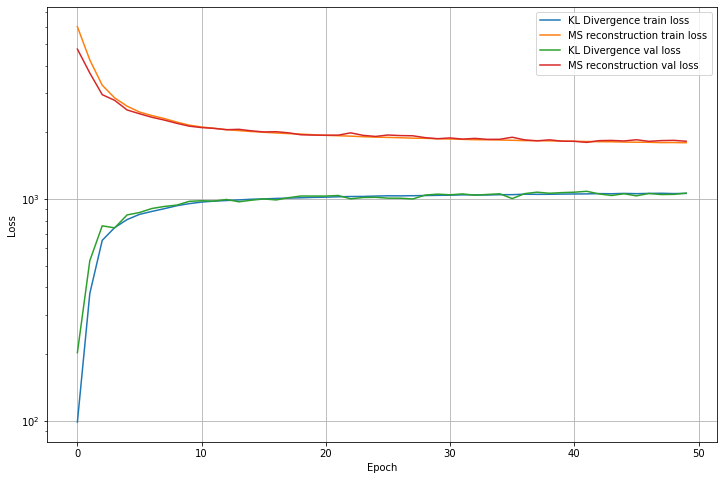

In [11]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_div_loss, label='KL Divergence train loss')
plt.semilogy(train_rec_loss, label='MS reconstruction train loss')
plt.semilogy(val_div_loss, label='KL Divergence val loss')
plt.semilogy(val_rec_loss, label='MS reconstruction val loss')
#plt.semilogy(np.sum(train_div_loss,train_rec_loss), label = "Total train loss")
#plt.semilogy(val_div_loss+val_rec_loss, label = "Total validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Save and load model

In [13]:
### Save network parameters
### Save the network state
# Save network parameters
torch.save(net.state_dict(), 'Vencoder_params.pth')
#torch.save(decoder.state_dict(), 'Vdecoder_params.pth')

In [14]:
### Reload the network state
# Load network parameters
net.load_state_dict(torch.load('Vencoder_params.pth'))
#decoder.load_state_dict(torch.load('Vdecoder_params.pth'))

<All keys matched successfully>

# Network analysis

In [15]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_data):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    net.eval()
    with torch.no_grad():
        mean, log_var  = encoder(img)
    # Append to list
    mean = mean.flatten().cpu().numpy()
    log_var = log_var.flatten().cpu().numpy()
    encoded_img = (mean,log_var)
 
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

  0%|          | 0/10000 [00:00<?, ?it/s]


NameError: name 'encoder' is not defined

In [ ]:
print(encoded_sample)

In [ ]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

In [ ]:

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
# Reconstruct images
# Get the output of a specific image (the test image at index 0 in this case)
img_indx = 100
img = test_data[img_indx][0].unsqueeze(0).to(device)
label = test_data[img_indx][1]
encoder.eval()
decoder.eval()
with torch.no_grad():
    mean, log_var, rec_img  = net(img)
    
# Plot the reconstructed image
fig, axs = plt.subplots(3, 2, figsize=(18,9))
axs[0,0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0,0].set_title('Original image: label %d' %label)
axs[0,1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0,1].set_title('Reconstructed image')
plt.tight_layout()

In [ ]:
### Generate random samples

figure = plt.figure(figsize=(8, 8))
cols, rows = 5,5


for i in range(1,cols * rows+1):
    # Generate a custom sample
    mean = [0.0]*encoded_space_dim
    log_var = [1.0]*encoded_space_dim
    mean = torch.tensor(mean).float().unsqueeze(0).to(device)
    log_var = torch.tensor(log_var).float().unsqueeze(0).to(device)
    
    # Sample
    sampled_data = Sampler(mean, log_var)
    
    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(sampled_data)
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap="gray")
plt.show()
    

In [ ]:
### Generate regular samples from encoded space

figure = plt.figure(figsize=(16, 16))
cols, rows = 15, 15

dim1 = np.linspace(-5,5,cols)
dim2 = np.linspace(-5,5,rows)

for i in range(cols):
    for j in range(rows):
        # Create  an encoded sample
        encoded_sample = [dim1[i], dim2[j]]
        encoded_sample = torch.tensor(encoded_sample).float().unsqueeze(0).to(device)
        
        # Decode sample
        decoder.eval()
        with torch.no_grad():
            generated_img  = decoder(encoded_sample)
        sample_idx = torch.randint(len(train_data), size=(1,)).item()
        img, label = train_data[sample_idx]
        figure.add_subplot(rows, cols, j*cols+1+i)
        plt.axis("off")
        plt.imshow(generated_img.squeeze().cpu().numpy(), cmap="gray")
plt.show()
